## Import

In [1]:
## IMPORT 

import os
import numpy as np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt, resample, savgol_filter
from scipy.stats import linregress, ttest_ind, pearsonr, wilcoxon
from scipy.optimize import curve_fit, minimize
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib as mpl
import h5py
from pathlib import Path
import glob
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.integrate import simpson
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression


## plotting params

In [2]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140

## data loading + sliding window function

In [10]:

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files
#OF 

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/OF_FP/OF_BLA/preprocessedcorrected'
of_files = glob.glob(os.path.join(directory, "*.csv"))

of_files

# SLIDING WINDOW FUNCTION
def create_sliding_window(df, signal_col, target_col, window_size, step_size=30):
    X, y = [], []
    for i in range(0, len(df) - window_size, step_size):
        window_signal = df[signal_col].iloc[i:i + window_size].values
        window_labels = df[target_col].iloc[i:i + window_size]
        if len(window_labels.unique()) == 1: 
            X.append(window_signal)
            y.append(window_labels.iloc[0])
    return np.array(X), np.array(y)

## individual mouse rep

Accuracy: 0.9230769230769231
Precision for class 1: 0.3076923076923077

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1130
         1.0       0.31      1.00      0.47        40

    accuracy                           0.92      1170
   macro avg       0.65      0.96      0.71      1170
weighted avg       0.98      0.92      0.94      1170


Confusion Matrix:
 [[1040   90]
 [   0   40]]


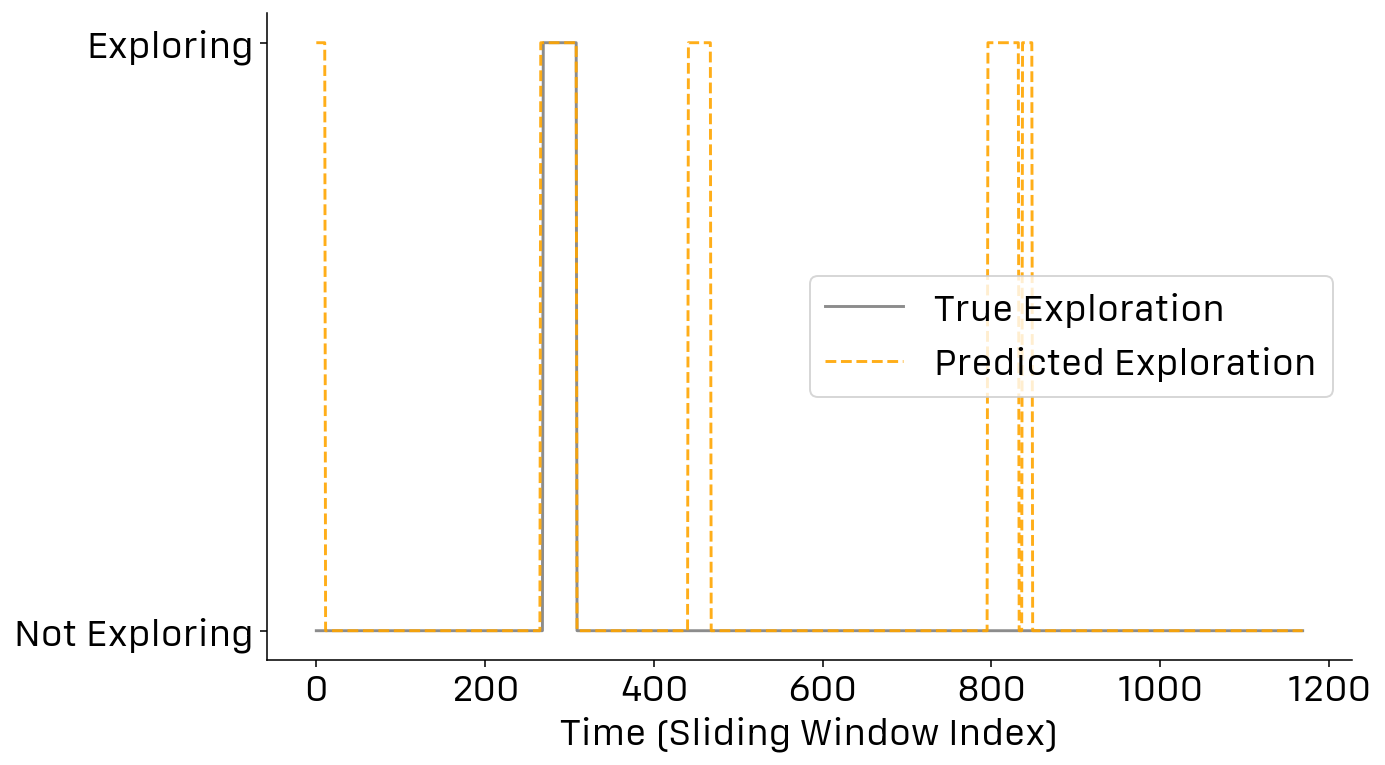

In [24]:

# Load the training and testing data
epm = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/129_F_preprocessed.csv')
sam = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/129_F_preprocessed.csv')

# Preprocess the training data
epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

# Preprocess the testing data
sam.loc[sam['In black'] == 1, 'exploration'] = 0
sam.loc[sam['In black'] == 0, 'exploration'] = 1
sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]


# Parameters
window_size = 300  # Sliding window size

# Prepare training and testing datasets
X_train, y_train = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
X_test, y_test = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)


# Oversample the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Train the SVM model
svm_model = LogisticRegression(random_state=42, C=0.001, max_iter=50000)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred = svm_model.predict(X_test)


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision for class 1:", precision_score(y_test, y_pred, pos_label=1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='True Exploration', color='grey', alpha=0.9)
plt.plot(range(len(y_test)), y_pred, label='Predicted Exploration', color='orange', linestyle='--', alpha=0.9)
plt.xlabel('Time (Sliding Window Index)')
plt.yticks([0, 1], ['Not Exploring', 'Exploring'])
plt.legend()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/SAMtoEPM_walkrep1028.pdf', format='pdf')
plt.show()

Accuracy: 0.9098873591989988
Precision for class 1: 0.6995305164319249

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       642
         1.0       0.70      0.95      0.81       157

    accuracy                           0.91       799
   macro avg       0.84      0.92      0.87       799
weighted avg       0.93      0.91      0.91       799


Confusion Matrix:
 [[578  64]
 [  8 149]]


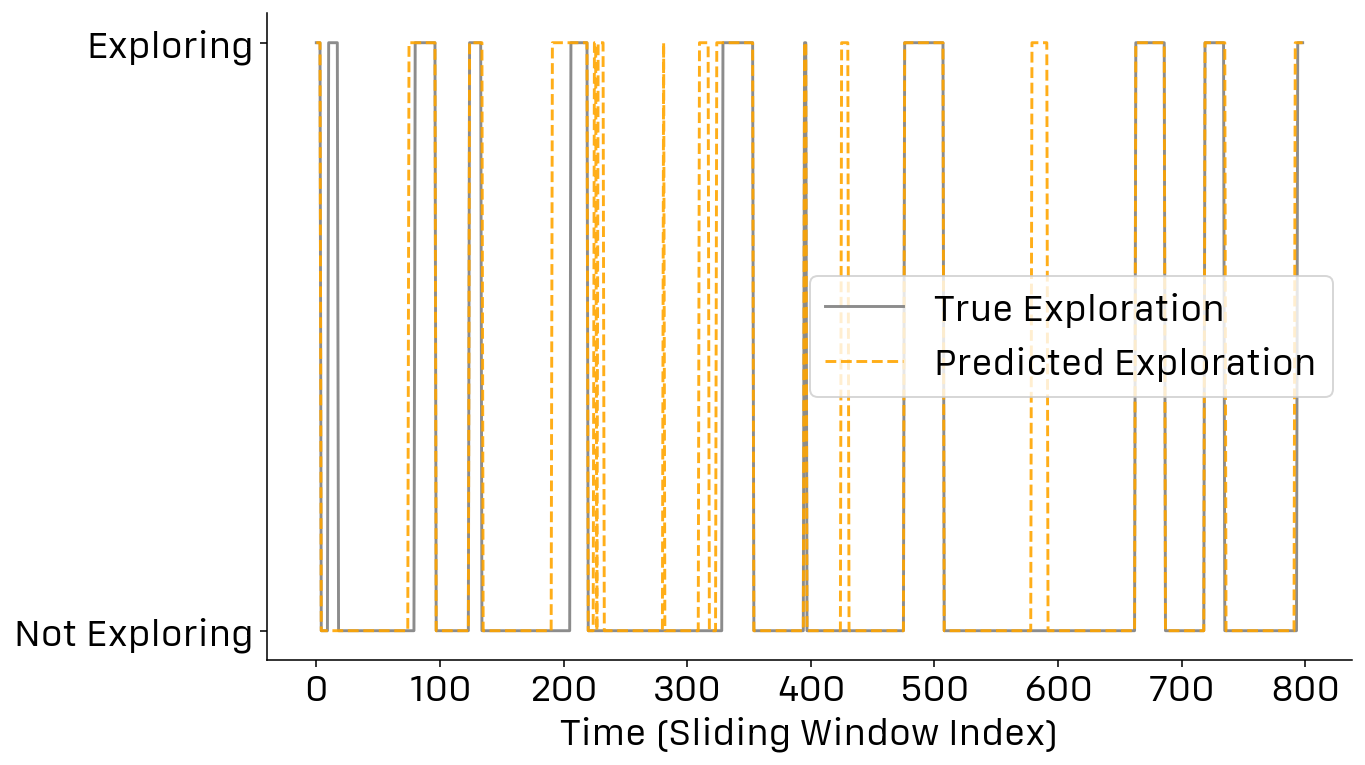

In [25]:

# Load the training and testing data
epm = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/1035_M_preprocessed.csv')
sam = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/1035_M_preprocessed.csv')

# Preprocess the training data
epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

# Preprocess the testing data
sam.loc[sam['In black'] == 1, 'exploration'] = 0
sam.loc[sam['In black'] == 0, 'exploration'] = 1
sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]


# Parameters
window_size = 300  # Sliding window size

# Prepare training and testing datasets
X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
X_test, y_test = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)


# Oversample the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Train the SVM model
svm_model = LogisticRegression(random_state=42, C=0.001, max_iter=50000)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred = svm_model.predict(X_test)


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision for class 1:", precision_score(y_test, y_pred, pos_label=1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='True Exploration', color='grey', alpha=0.9)
plt.plot(range(len(y_test)), y_pred, label='Predicted Exploration', color='orange', linestyle='--', alpha=0.9)
plt.xlabel('Time (Sliding Window Index)')
plt.yticks([0, 1], ['Not Exploring', 'Exploring'])
plt.legend()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_walkrep1035.pdf', format='pdf')
plt.show()


## full decoder

#### of decoder

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

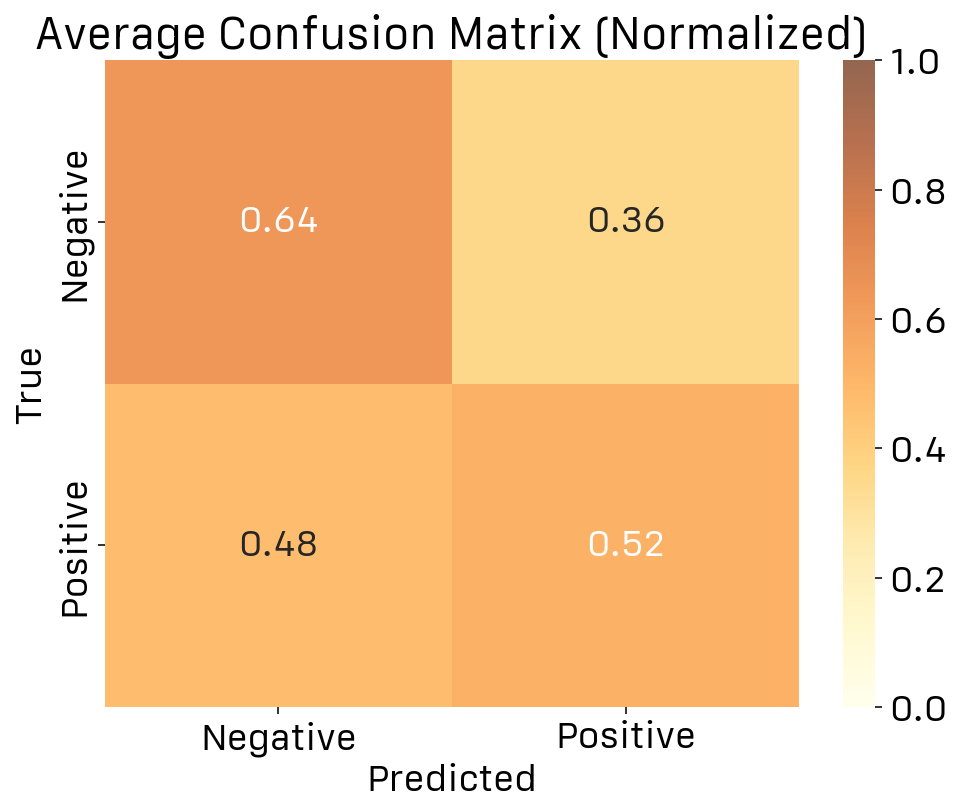

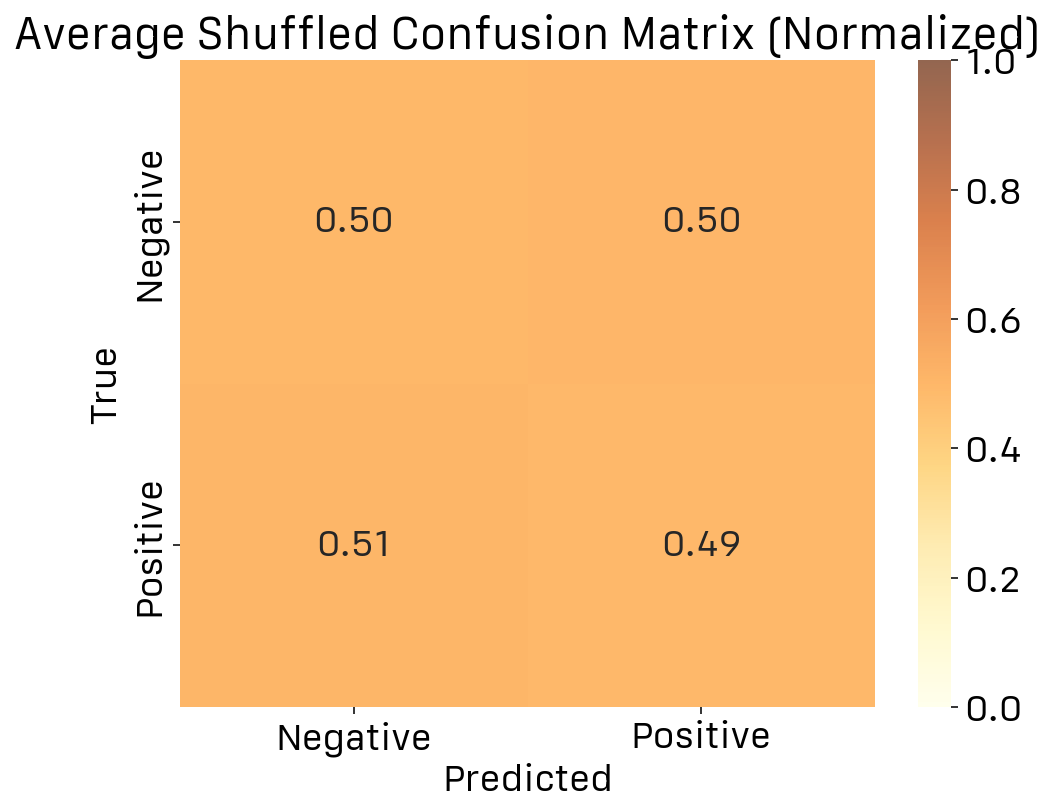

In [ ]:
# ## One decoder per mouse, output average confusion matrix 

# # Initialize results storage
# confusion_matrices = []
# shuffled_confusion_matrices = []
# results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [],
#            'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
#            'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': []}

# num_repeats = 10  # number of under-sampling repeats

# for efile, sfile, ofile in zip(epm_files, sam_files, of_files):
#     epm = pd.read_csv(efile)
#     sam = pd.read_csv(sfile)
#     of = pd.read_csv(ofile)

#     id = epm['ID'].iloc[0]

#     # Label assignment
#     epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
#     sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)
#     of['exploration'] = np.where(of['In outer'] == 1, 0, 1)

#     epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]
#     sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]
#     of = of[['Zscoreg', 'Time', 'exploration', 'ID']]

#     window_size = 300

#     X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
#     X_test, y_test = create_sliding_window(of, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

#     for repeat_idx in range(num_repeats):
#         print(f"Repeat {repeat_idx + 1}/{num_repeats}")

#         # Random undersampling
#         undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
#         X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

#         # Hyperparameter tuning
#         param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
#         lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
#         grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
#         grid_search.fit(X_train_resampled, y_train_resampled)

#         # Get best model
#         best_model = grid_search.best_estimator_
#         best_model.fit(X_train_resampled, y_train_resampled)
        
#         # Predict probabilities for AUC-ROC calculation
#         y_pred_proba = best_model.predict_proba(X_test)
#         y_pred = best_model.predict(X_test)

#         # Compute AUC-ROC
#         auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

#         # Evaluate model
#         cm = confusion_matrix(y_test, y_pred, normalize='true')
#         confusion_matrices.append(cm)

#         report = classification_report(y_test, y_pred, output_dict=True)
#         results['ID'].append(id)
#         results['Accuracy'].append(report['accuracy'])
#         results['Precision'].append(report['weighted avg']['precision'])
#         results['Recall'].append(report['weighted avg']['recall'])
#         results['F1'].append(report['weighted avg']['f1-score'])
#         results['1_f1'].append(report['1']['f1-score'])
#         results['0_f1'].append(report['0']['f1-score'])
#         results['AUC_ROC'].append(auc_roc)

#         # Shuffle and evaluate
#         num_permutations = 50
#         shuffled_cm_list = []
#         shuffled_results_list = []

#         for i in range(num_permutations):
#             np.random.seed(42 + i)
#             np.random.shuffle(y_train_resampled)

#             best_model.fit(X_train_resampled, y_train_resampled)
#             y_pred_shuffled_proba = best_model.predict_proba(X_test)
#             y_pred_shuffled = best_model.predict(X_test)

#             shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

#             shuffled_report = classification_report(y_test, y_pred_shuffled, output_dict=True)
#             shuffled_results_list.append({
#                 'Shuffled_Accuracy': shuffled_report['accuracy'],
#                 'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
#                 'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
#                 'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
#                 'Shuffled_1_f1': shuffled_report['1']['f1-score'],
#                 'Shuffled_0_f1': shuffled_report['0']['f1-score'],
#                 'Shuffled_AUC_ROC': shuffled_auc_roc
#             })

#             cm_shuffled = confusion_matrix(y_test, y_pred_shuffled, normalize='true')
#             shuffled_cm_list.append(cm_shuffled)

#         avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
#         shuffled_average_results = {
#             key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
#         }

#         results['Shuffled_ID'].append(id)
#         results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
#         results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
#         results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
#         results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
#         results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
#         results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
#         results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])

#         shuffled_confusion_matrices.append(avg_shuffled_cm)

# # Average confusion matrices
# average_cm = np.mean(confusion_matrices, axis=0)
# shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)

# # Calculate average results for each ID
# average_results = pd.DataFrame(results).groupby('ID').mean()
# print(average_results)

# # Plot confusion matrices
# plt.figure(figsize=(8, 6))
# sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_CM.pdf', format='pdf')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.show()


### sam to epm - epm to sam 

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

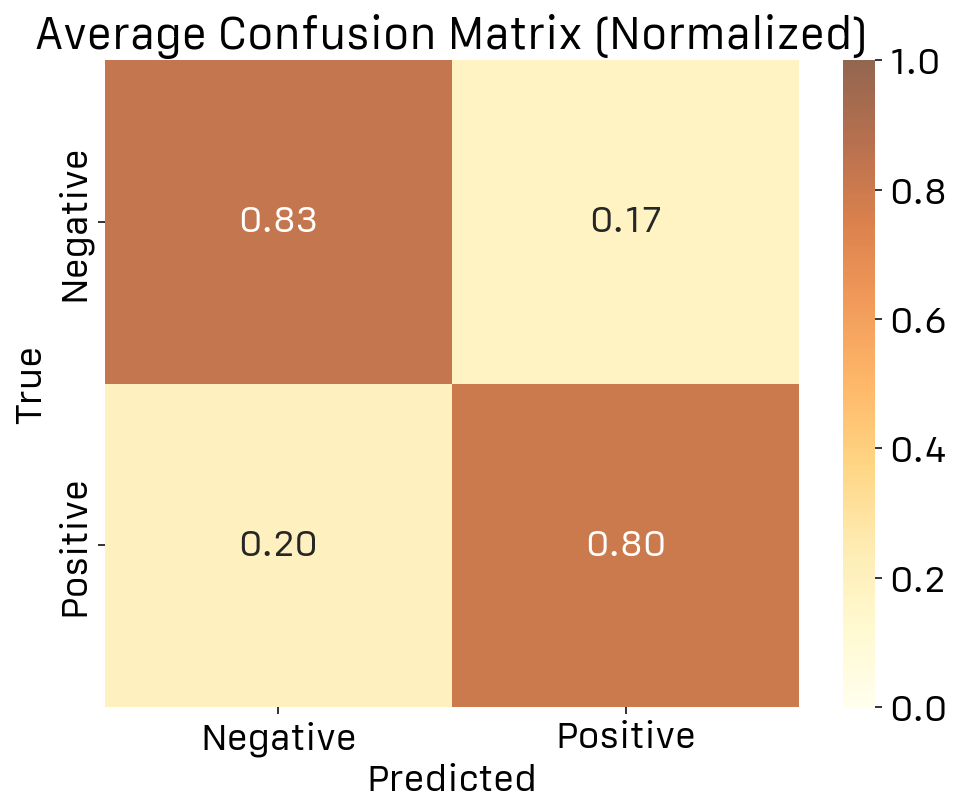

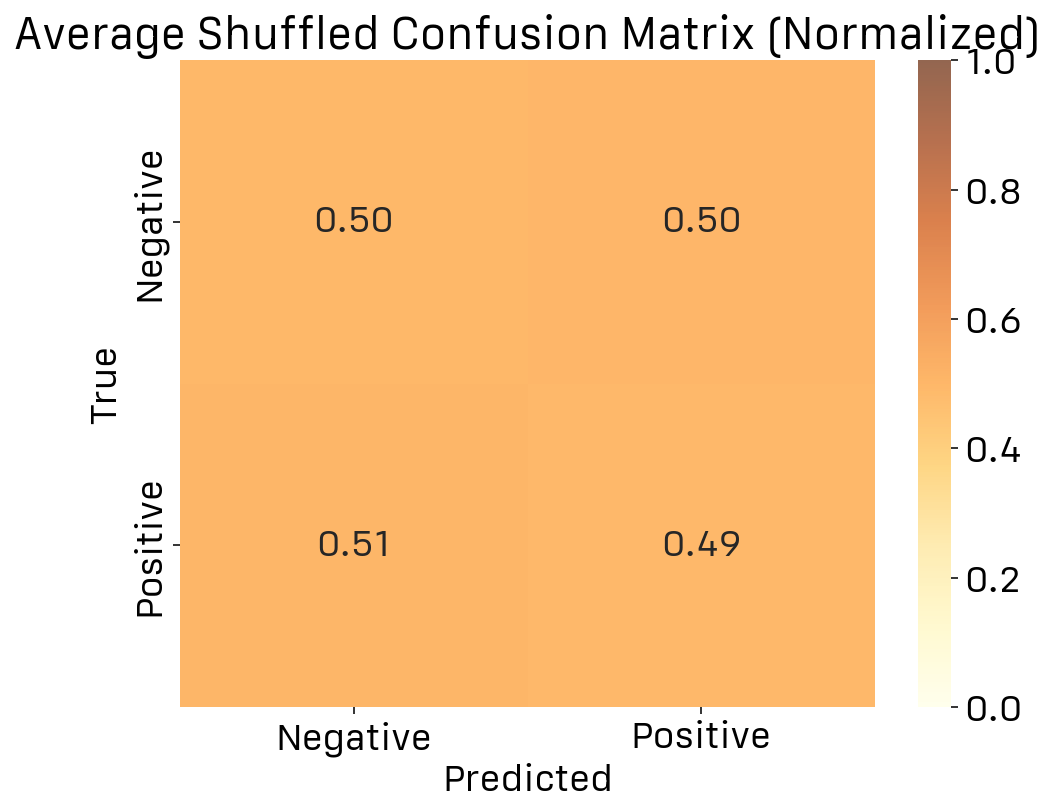

In [29]:
## One decoder per mouse, output average confusion matrix 

# Initialize results storage
confusion_matrices = []
shuffled_confusion_matrices = []
results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': []}

num_repeats = 10  # number of under-sampling repeats

for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_test, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_results_list = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_test)
            y_pred_shuffled = best_model.predict(X_test)

            shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_test, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_test, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)

        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }

        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])

        shuffled_confusion_matrices.append(avg_shuffled_cm)

# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_CM.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.show()


## results bar plots

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.570526   0.773231  0.570526  0.654619  0.017900  0.723989  0.357591   
118   0.654481   0.981626  0.654481  0.780825  0.035209  0.789271  0.668224   
129   0.698454   0.913092  0.698454  0.790224  0.010989  0.821544  0.251119   
1028  0.644039   0.995842  0.644039  0.779165  0.023099  0.782360  0.739765   
1034  0.620256   0.977240  0.620256  0.754377  0.032605  0.763730  0.554311   
1035  0.647573   0.981597  0.647573  0.773716  0.052898  0.783469  0.734038   
1045  0.624010   0.993559  0.624010  0.764235  0.010380  0.767044  0.689855   
1046  0.703122   0.963889  0.703122  0.794243  0.197422  0.817850  0.874148   
1050  0.572871   0.971070  0.572871  0.715826  0.028739  0.726092  0.551593   
1051  0.562953   0.820870  0.562953  0.649391  0.161091  0.703490  0.531010   
1052  0.671759   0.868917  0.671759  0.741914  0.224

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_97873/2541466025.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


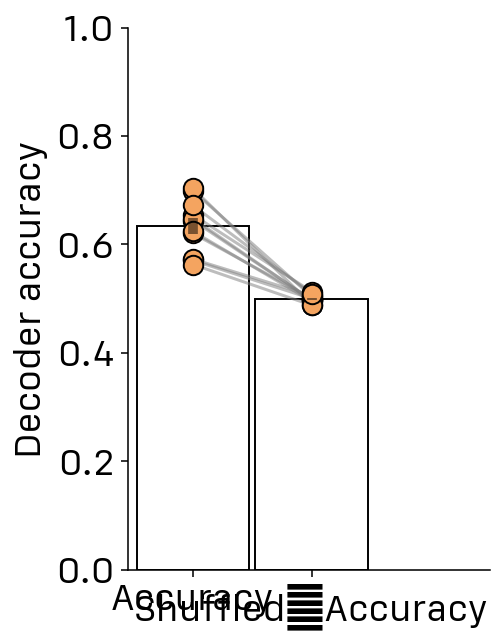

In [12]:

df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Shuffled_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Shuffled_Accuracy'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Shuffled_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Accuracy.pdf', format='pdf')
plt.show()

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_31746/1254760728.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_31746/1254760728.py:31: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_F1.pdf', format='pdf')
trak NOT subset; don't know how to subset; dropped


      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
63    0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64    0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65    0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66    0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851957   
67    0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68    0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70    0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71    0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84    0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
116   0.767534   0.934053  0.767534  0.816337  0.429873  0.853995  0.950860   
118   0.500455   0.934933  0.500455  0.633854  0.077

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


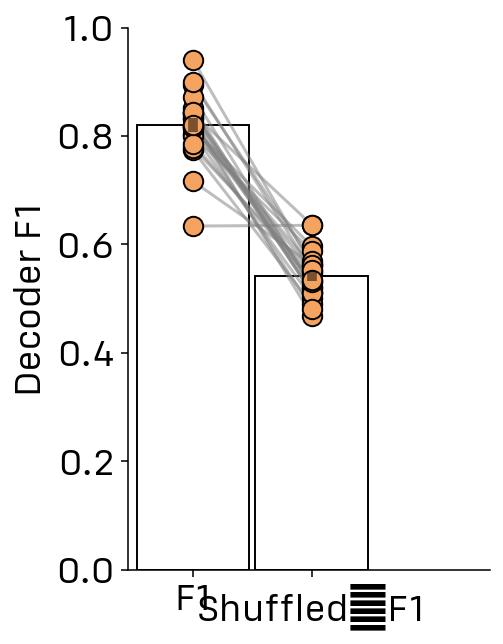

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Shuffled_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Shuffled_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Shuffled_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_F1.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.853879   0.905393  0.853879  0.867446  0.661028  0.906612  0.949666   
118   0.684221   0.774362  0.684221  0.722463  0.148891  0.805327  0.455211   
129   0.931921   0.983512  0.931921  0.951798  0.375314  0.963960  0.990464   
1028  0.673046   0.831135  0.673046  0.726387  0.305630  0.786166  0.717708   
1034  0.874946   0.930478  0.874946  0.887900  0.711956  0.920134  0.985478   
1035  0.892741   0.921458  0.892741  0.899412  0.776729  0.929413  0.968414   
1045  0.875601   0.917834  0.875601  0.889088  0.616158  0.925597  0.914286   
1046  0.791805   0.897634  0.791805  0.819252  0.565441  0.863097  0.935603   
1050  0.808149   0.830116  0.808149  0.816063  0.606634  0.873113  0.865438   
1051  0.873386   0.910916  0.873386  0.883879  0.686017  0.920669  0.951158   
1052  0.779634   0.960234  0.779634  0.846018  0.243

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3142920318.py:29: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3142920318.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


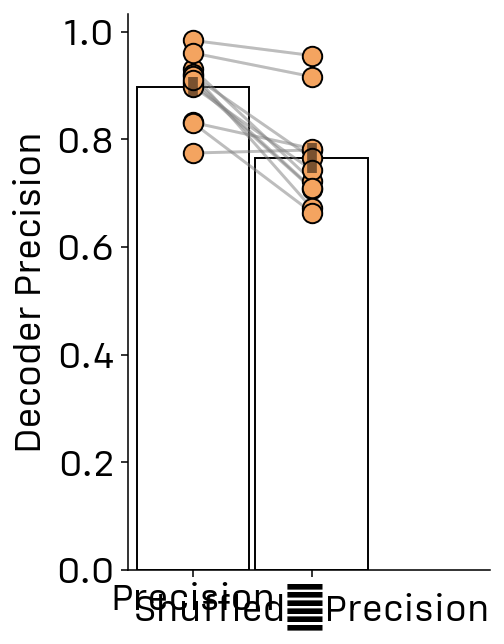

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision', 'Shuffled_Precision']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Shuffled_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Shuffled_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Precision.pdf', format='pdf')
plt.show()

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_31746/2926735648.py:29: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_31746/2926735648.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Recall.pdf', format='pdf')
trak NOT subset; don't know how to subset; dropped


      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
63    0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64    0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65    0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66    0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851957   
67    0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68    0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70    0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71    0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84    0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
116   0.767534   0.934053  0.767534  0.816337  0.429873  0.853995  0.950860   
118   0.500455   0.934933  0.500455  0.633854  0.077

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


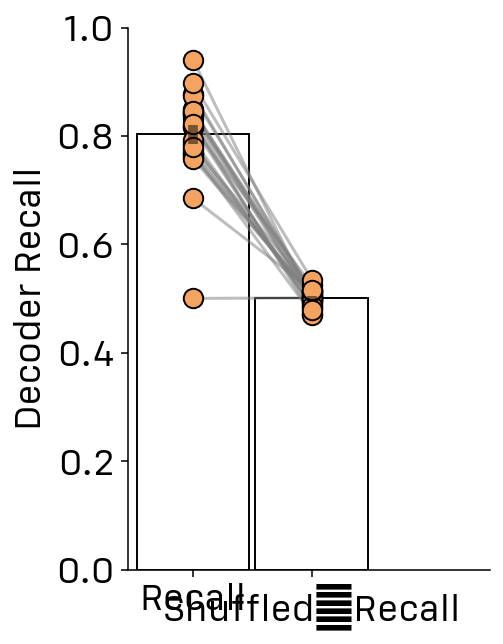

In [ ]:


df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Shuffled_Recall']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall'], df['Shuffled_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Shuffled_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Recall.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
63    0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64    0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65    0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66    0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851957   
67    0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68    0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70    0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71    0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84    0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
116   0.767534   0.934053  0.767534  0.816337  0.429873  0.853995  0.950860   
118   0.500455   0.934933  0.500455  0.633854  0.077

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_31746/1278522703.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


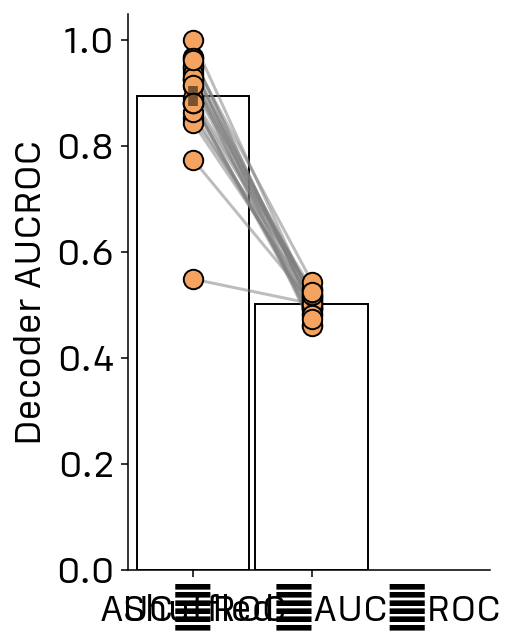

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC', 'Shuffled_AUC_ROC']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC'], df['Shuffled_AUC_ROC'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC'], row['Shuffled_AUC_ROC']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder AUCROC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/SAMtoEPM_AUC_ROC.pdf', format='pdf')
plt.show()

## ROC 

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

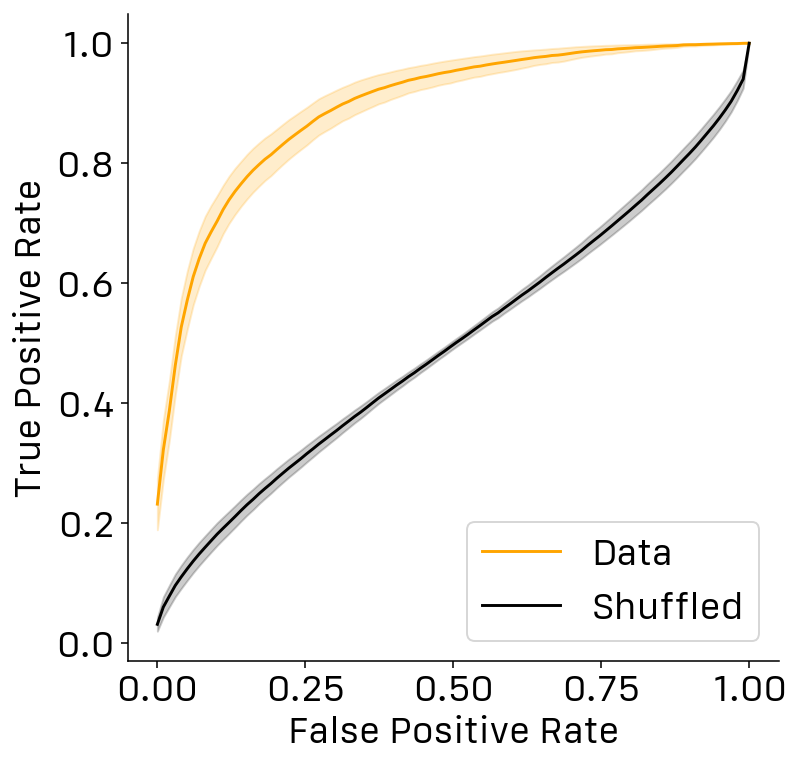

In [ ]:


# Initialize results storage
confusion_matrices = []
shuffled_confusion_matrices = []
roc_data = {}  # Store per-mouse ROC data
shuffled_roc_data = {}  # Store per-mouse shuffled ROC data

num_repeats = 10  # number of under-sampling repeats



for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    mouse_roc_curves = []  # Store ROC curves for each repeat
    shuffled_roc_curves = []  # Store shuffled ROC curves for each repeat

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Compute ROC curve and store it
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        mouse_roc_curves.append((fpr, tpr))

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_ind_roc_curves = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_test)
            y_pred_shuffled = best_model.predict(X_test)

            shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

            # Compute ROC curve and store it
            shuffled_ind_fpr, shuffled_ind_tpr, _ = roc_curve(y_test, y_pred_shuffled_proba[:, 1])
            shuffled_ind_roc_curves.append((shuffled_ind_fpr, shuffled_ind_tpr))

    # Compute per-mouse average ROC
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    shuffled_trps = []

    for shuffled_fpr, shuffled_tpr in shuffled_ind_roc_curves:
        interp_tpr = np.interp(mean_fpr, shuffled_fpr, shuffled_tpr)
        shuffled_trps.append(interp_tpr)

    for fpr, tpr in mouse_roc_curves:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPR values
        tprs.append(interp_tpr)



    mean_tpr = np.mean(tprs, axis=0)
    mean_shuffled_tpr = np.mean(shuffled_trps, axis=0)
    std_tpr = np.std(tprs, axis=0)
    shuffled_std_tpr = np.std(shuffled_trps, axis=0)

    # plt.plot(mean_fpr, mean_tpr, color='orange', alpha=0.2)  
    # plt.plot(mean_fpr, mean_shuffled_tpr, color='black', alpha=0.2)

    roc_data[id] = (mean_fpr, mean_tpr, std_tpr)
    shuffled_roc_data[id] = (mean_fpr, mean_shuffled_tpr, shuffled_std_tpr)

# Compute overall mean ROC curve across mice
all_mean_tprs = []
shuffled_all_mean_tprs = []
all_mean_fprs = np.linspace(0, 1, 100)

for mouse_id in shuffled_roc_data:
    shuffled_all_mean_tprs.append(np.interp(all_mean_fprs, shuffled_roc_data[mouse_id][0], shuffled_roc_data[mouse_id][1]))

shuffled_final_mean_tpr = np.mean(shuffled_all_mean_tprs, axis=0)
shuffled_final_sem_tpr = np.std(shuffled_all_mean_tprs, axis=0) / np.sqrt(len(shuffled_all_mean_tprs))

for mouse_id in roc_data:
    all_mean_tprs.append(np.interp(all_mean_fprs, roc_data[mouse_id][0], roc_data[mouse_id][1]))

final_mean_tpr = np.mean(all_mean_tprs, axis=0)
final_sem_tpr = np.std(all_mean_tprs, axis=0) / np.sqrt(len(all_mean_tprs))

# Plot mean ROC curve with standard deviation

plt.figure(figsize=(6, 6))
plt.plot(all_mean_fprs, final_mean_tpr, color='orange', label='Data')
plt.plot(all_mean_fprs, shuffled_final_mean_tpr, color='black', label='Shuffled')
plt.fill_between(all_mean_fprs, final_mean_tpr - final_sem_tpr, final_mean_tpr + final_sem_tpr, color='orange', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_mean_tpr - shuffled_final_sem_tpr, shuffled_final_mean_tpr + shuffled_final_sem_tpr, color='black', alpha=0.2)

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


trak NOT subset; don't know how to subset; dropped


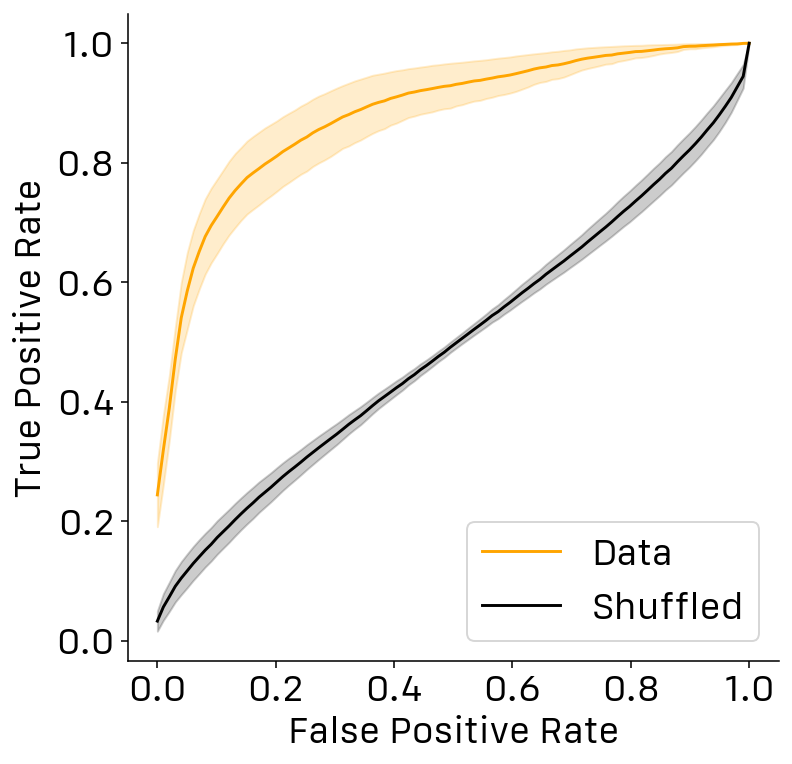

In [ ]:
##Plotting
plt.figure(figsize=(6, 6))

plt.plot(all_mean_fprs, final_mean_tpr, color='orange', label='Data')
plt.plot(all_mean_fprs, shuffled_final_mean_tpr, color='black', label='Shuffled')
plt.fill_between(all_mean_fprs, final_mean_tpr - final_sem_tpr, final_mean_tpr + final_sem_tpr, color='orange', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_mean_tpr - shuffled_final_sem_tpr, shuffled_final_mean_tpr + shuffled_final_sem_tpr, color='black', alpha=0.2)

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0, .2, .4, .6, .8, 1])
plt.yticks([0, .2, .4, .6, .8, 1])
plt.legend()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_ROC_curveC.pdf', format='pdf')
plt.show()

Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1
Repeat 1/1


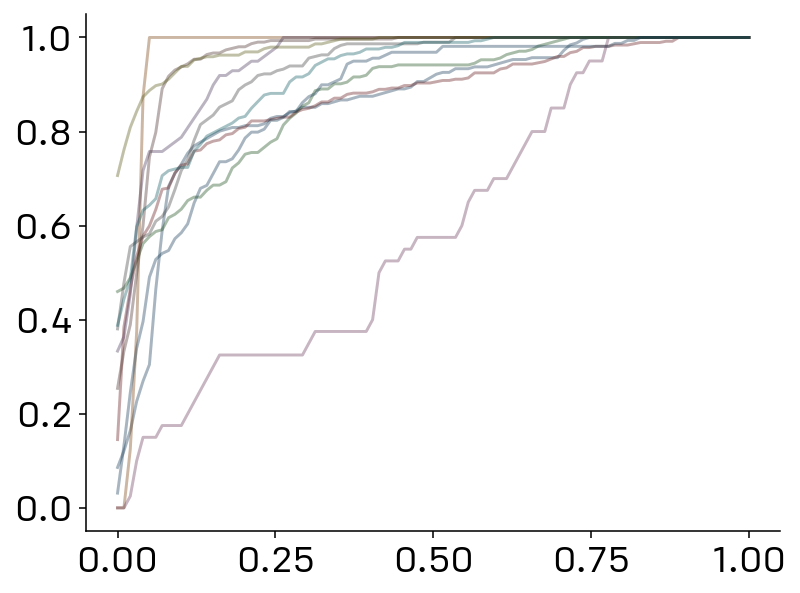

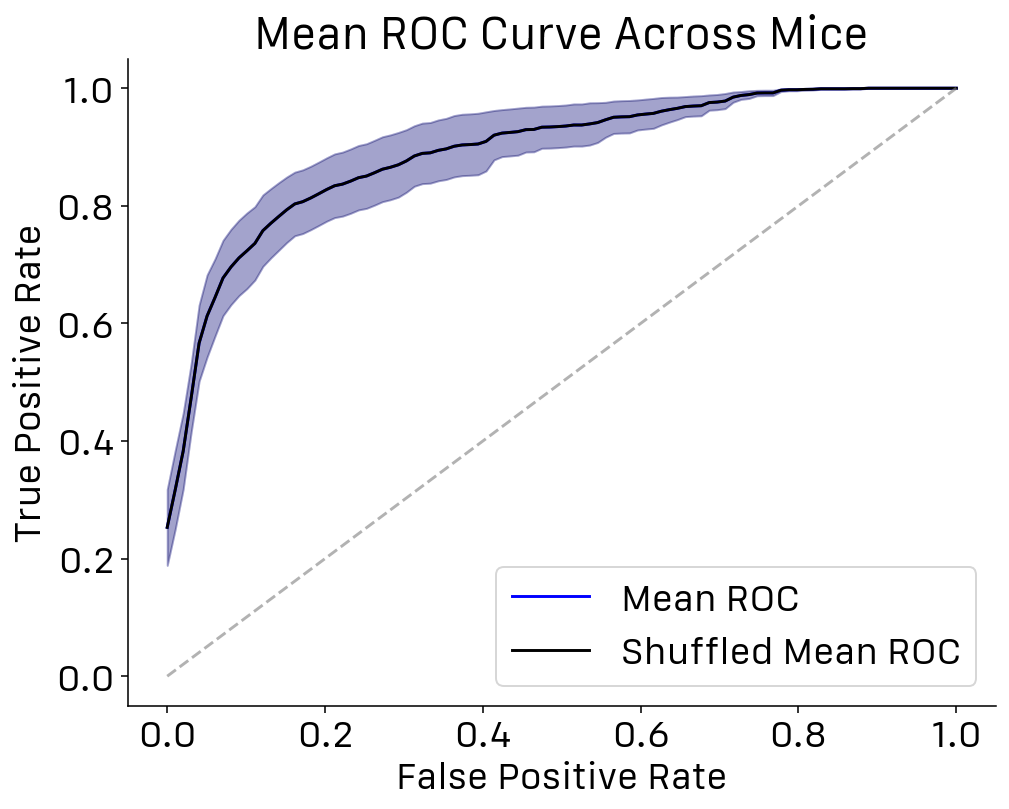

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.under_sampling import RandomUnderSampler

# Initialize results storage
confusion_matrices = []
shuffled_confusion_matrices = []
roc_data = {}  # Store per-mouse ROC data
shuffled_roc_data = {}  # Store per-mouse shuffled ROC data


num_repeats = 1  # number of under-sampling repeats

for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    mouse_roc_curves = []  # Store ROC curves for each repeat
    shuffled_roc_curves = []  # Store shuffled ROC curves for each repeat

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Compute ROC curve and store it
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        mouse_roc_curves.append((fpr, tpr))

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_results_list = []

        shuffled_ind_roc_curves = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_test)
            y_pred_shuffled = best_model.predict(X_test)

            shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

            # Compute ROC curve and store it
            shuffled_ind_fpr, shuffled_ind_tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
            shuffled_ind_roc_curves.append((shuffled_ind_fpr, shuffled_ind_tpr))



    # Compute per-mouse average ROC
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    shuffled_trps = []

    for shuffled_fpr, shuffled_tpr in shuffled_ind_roc_curves:
        interp_tpr = np.interp(mean_fpr, shuffled_fpr, shuffled_tpr)
        shuffled_trps.append(interp_tpr)

    for fpr, tpr in mouse_roc_curves:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPR values
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_shuffled_tpr = np.mean(shuffled_trps, axis=0)
    std_tpr = np.std(tprs, axis=0)
    shufffled_std_tpr = np.std(shuffled_trps, axis=0)

    plt.plot(mean_fpr, mean_tpr, alpha=0.2)  

    roc_data[id] = (mean_fpr, mean_tpr, std_tpr)
    shuffled_roc_data[id] = (mean_fpr, mean_shuffled_tpr, shufffled_std_tpr)

    mean_shuffled_tpr = np.mean(shuffled_trps, axis=0)
    mean_shuffled_std_tpr = np.std(shuffled_trps, axis=0)

    plt.plot(mean_fpr, mean_shuffled_tpr, color = 'black', alpha=0.2)

# Compute overall mean ROC curve across mice
all_mean_tprs = []
shuffled_all_mean_tprs = []
all_mean_fprs = np.linspace(0, 1, 100)

for mouse_id in shuffled_roc_data:
    shuffled_all_mean_tprs.append(np.interp(all_mean_fprs, shuffled_roc_data[mouse_id][0], shuffled_roc_data[mouse_id][1]))

shuffled_final_mean_tpr = np.mean(shuffled_all_mean_tprs, axis=0)
shuffled_final_sem_tpr = np.std(shuffled_all_mean_tprs, axis=0) / np.sqrt(len(shuffled_all_mean_tprs))

for mouse_id in roc_data:
    all_mean_tprs.append(np.interp(all_mean_fprs, roc_data[mouse_id][0], roc_data[mouse_id][1]))

final_mean_tpr = np.mean(all_mean_tprs, axis=0)
final_sem_tpr = np.std(all_mean_tprs, axis=0) / np.sqrt(len(all_mean_tprs))

# Plot mean ROC curve with standard deviation
plt.figure(figsize=(8, 6))
plt.plot(all_mean_fprs, final_mean_tpr, color='blue', label='Mean ROC')
plt.plot(all_mean_fprs, shuffled_final_mean_tpr, color='black', label='Shuffled Mean ROC')
plt.fill_between(all_mean_fprs, final_mean_tpr - final_sem_tpr, final_mean_tpr + final_sem_tpr, color='blue', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_mean_tpr - shuffled_final_sem_tpr, shuffled_final_mean_tpr + shuffled_final_sem_tpr, color='black', alpha=0.2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve Across Mice')
plt.legend()
plt.show()



Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10
Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10
Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10
Repeat 1/10
Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10
Repeat 3/10
Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.92857

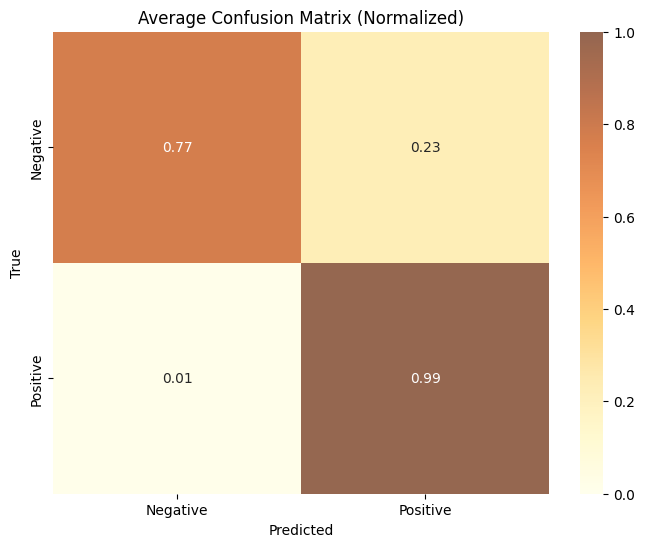

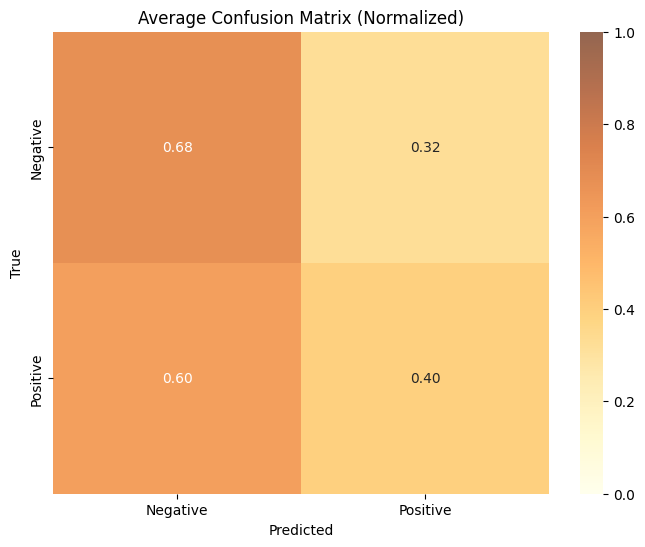

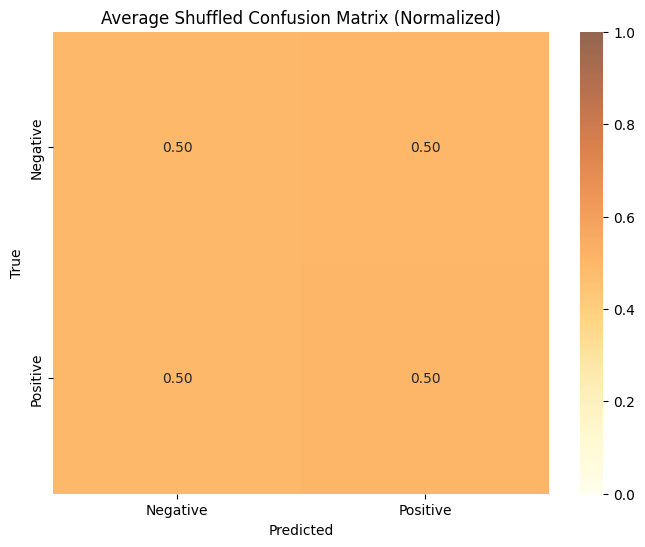

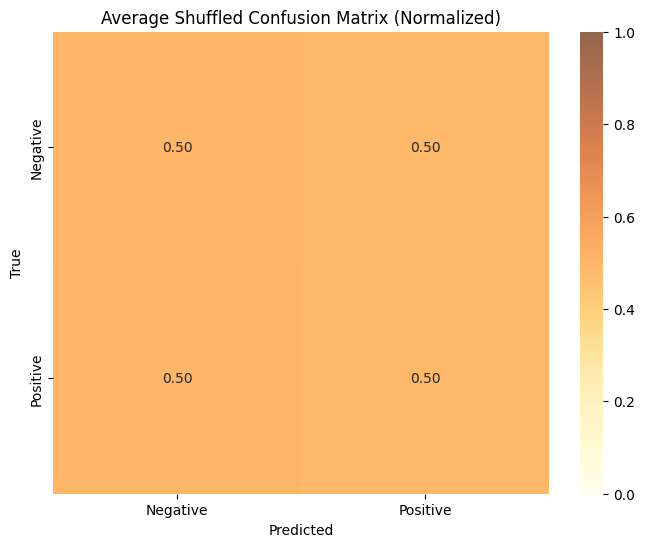

In [4]:
### DECODER FIRST EXPLO VS REST 

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files


#Ymaze

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/preprocessed/'
ymaze_files = glob.glob(os.path.join(directory, "*.csv"))

ymaze_files


# Initialize results storage
confusion_matrices = []
confusion_matrices2 = []
shuffled_confusion_matrices = []
shuffled_confusion_matrices2 = []

results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [], 'Accuracy2': [], 
              'Precision2': [], 'Recall2': [], 'F12': [], '1_f12': [], '0_f12': [], 'AUC_ROC2': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': [], 
           'Shuffled_Accuracy2': [], 'Shuffled_Precision2': [], 'Shuffled_Recall2': [],
           'Shuffled_F12': [], 'Shuffled_1_f12': [], 'Shuffled_0_f12': [], 'Shuffled_AUC_ROC2': []}

num_repeats = 10  # number of under-sampling repeats


for efile, sfile, yfile, in zip(epm_files, sam_files, ymaze_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)

    ym = pd.read_csv(yfile)

    id=epm['ID'].iloc[0]

    # Preprocess epm data
    epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
    epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Preprocess sam data
    sam.loc[sam['In black'] == 1, 'exploration'] = 0
    sam.loc[sam['In black'] == 0, 'exploration'] = 1
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Concat epm + sam
    epm_sam = pd.concat([epm, sam], axis=0)


    # Preprocess ym data


    ym['In farm'] = 0
    ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1


  
    explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    ymtest = ym.loc[explostart:]

    nexplostart = ymtest[(ymtest['In farm'].shift() == 0) & (ymtest['In farm'] == 1)].index
    nexploend = ymtest[(ymtest['In farm'].shift() == 1) & (ymtest['In farm'] == 0)].index

    validnexplostart = []
    validnexploend = []

    for start, end in zip(nexplostart, nexploend):
        if end-start > 300:  ### keep only the first explo that is longer than 5 seconds
            validnexplostart.append(start)
            validnexploend.append(end)


    ymfirstexplo = pd.concat([ym.loc[explostart:exploend], ym.loc[validnexplostart[0]:validnexploend[0]]])


    ymfirstexplo['exploration'] = 0
    ymfirstexplo.loc[ymfirstexplo['In Novelarm'] == 1, 'exploration'] = 1

    ### dataset against other explo 

    ymotherexplo = ym.loc[validnexploend[0]:]
    ymotherexplo = ymotherexplo[(ymotherexplo['In Novelarm'] == 1) | (ymotherexplo['In farm'] == 1)]


    ymotherexplo['exploration'] = 0
    ymotherexplo.loc[ymotherexplo['In Novelarm'] == 1, 'exploration'] = 1
    ymotherexplo.loc[ymotherexplo['In farm'] == 1, 'exploration'] = 0




    # Parameters
    window_size = 300  # Sliding window size

    # Prepare training and testing datasets
    X_train, y_train = create_sliding_window(epm_sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_testfirstexplo, y_testfirstexplo = create_sliding_window(ymfirstexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_testotherexplo, y_testotherexplo = create_sliding_window(ymotherexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        ## Model training ##############################

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)

         ## Model evaluation FIRST explo ##############################

        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testfirstexplo)

        y_pred = best_model.predict(X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_testfirstexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_testfirstexplo, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_testfirstexplo, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)

         ## Model evaluation ALL OTHER EXPLO ##############################


        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testotherexplo)
        y_pred = best_model.predict(X_testotherexplo)

        # Compute AUC-ROC
        auc_roc2 = roc_auc_score(y_testotherexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm2 = confusion_matrix(y_testotherexplo, y_pred, normalize='true')
        confusion_matrices2.append(cm2)

        report = classification_report(y_testotherexplo, y_pred, output_dict=True)
        results['Accuracy2'].append(report['accuracy'])
        results['Precision2'].append(report['weighted avg']['precision'])
        results['Recall2'].append(report['weighted avg']['recall'])
        results['F12'].append(report['weighted avg']['f1-score'])
        results['1_f12'].append(report['1']['f1-score'])
        results['0_f12'].append(report['0']['f1-score'])
        results['AUC_ROC2'].append(auc_roc)



        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_cm_list2 = []
        shuffled_results_list = []
        shuffled_results_list2 = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            ####### first explo

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testfirstexplo)
            y_pred_shuffled = best_model.predict(X_testfirstexplo)

            shuffled_auc_roc = roc_auc_score(y_testfirstexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_testfirstexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_testfirstexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)

            ######## other explo

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testotherexplo)
            y_pred_shuffled = best_model.predict(X_testotherexplo)

            shuffled_auc_roc2 = roc_auc_score(y_testotherexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report2 = classification_report(y_testotherexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list2.append({
                'Shuffled_Accuracy2': shuffled_report2['accuracy'],
                'Shuffled_Precision2': shuffled_report2['weighted avg']['precision'],
                'Shuffled_Recall2': shuffled_report2['weighted avg']['recall'],
                'Shuffled_F12': shuffled_report2['weighted avg']['f1-score'],
                'Shuffled_1_f12': shuffled_report2['1']['f1-score'],
                'Shuffled_0_f12': shuffled_report2['0']['f1-score'],
                'Shuffled_AUC_ROC2': shuffled_auc_roc2
            })

            cm_shuffled2 = confusion_matrix(y_testotherexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list2.append(cm_shuffled2)

        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        avg_shuffled_cm2 = np.mean(shuffled_cm_list2, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }
        shuffled_average_results2 = {
            key: np.mean([res[key] for res in shuffled_results_list2]) for key in shuffled_results_list2[0]
        }

        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])


        results['Shuffled_Accuracy2'].append(shuffled_average_results2['Shuffled_Accuracy2'])
        results['Shuffled_Precision2'].append(shuffled_average_results2['Shuffled_Precision2'])
        results['Shuffled_Recall2'].append(shuffled_average_results2['Shuffled_Recall2'])
        results['Shuffled_F12'].append(shuffled_average_results2['Shuffled_F12'])
        results['Shuffled_1_f12'].append(shuffled_average_results2['Shuffled_1_f12'])
        results['Shuffled_0_f12'].append(shuffled_average_results2['Shuffled_0_f12'])
        results['Shuffled_AUC_ROC2'].append(shuffled_average_results2['Shuffled_AUC_ROC2'])

        shuffled_confusion_matrices.append(avg_shuffled_cm)
        shuffled_confusion_matrices2.append(avg_shuffled_cm2)

# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
average_cm2 = np.mean(confusion_matrices2, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)
shuffled_average_cm2 = np.mean(shuffled_confusion_matrices2, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices

#### DATA FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexplo.pdf', format='pdf')
plt.show()


### DATA OTHER EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexplo.pdf', format='pdf')
plt.show()

### SHUFFLED FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexploSHUFFLED.pdf', format='pdf')
plt.show()

### SHUFFLED OTHER EXPLO

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexploSHUFFLED.pdf', format='pdf')
plt.show()



In [91]:
df = average_results.copy()
df['ID'] = df.index  
df = df.reset_index(drop=True)  
print(df)


    Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
0   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
1   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
2   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
3   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4   0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
5   0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
6   0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
7   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
8   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
9   0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
10  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

    Accuracy2  Precision2   Recall2  ...  Shuffled_0_f1  Shuffled_AUC_ROC  

Accuracy     0.883745
Accuracy2    0.535778
dtype: float64
TtestResult(statistic=4.805616735128717, pvalue=0.00010759963912434618, df=20.0)


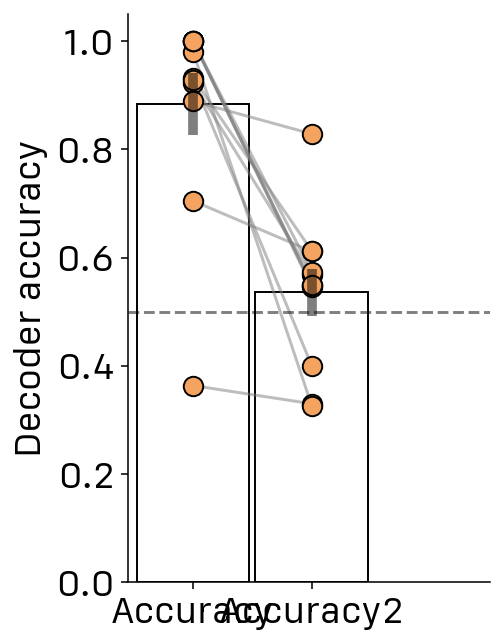

In [92]:

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Accuracy2']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Accuracy2'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Accuracy2']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_Accuracy.pdf', format='pdf')
plt.show()

trak NOT subset; don't know how to subset; dropped


      ID  condition     value  jittered_x
0    116   Accuracy  0.363636    0.191394
1    118   Accuracy  0.923077    0.063501
2    129   Accuracy  0.932258    0.006726
3   1028   Accuracy  1.000000   -0.142322
4   1034   Accuracy  0.980000   -0.109449
5   1035   Accuracy  0.888889    0.195435
6   1045   Accuracy  0.704762   -0.077120
7   1046   Accuracy  1.000000   -0.114890
8   1050   Accuracy  1.000000    0.072339
9   1051   Accuracy  0.928571    0.094506
10  1052   Accuracy  1.000000    0.072012
11   116  Accuracy2  0.329949    0.964895
12   118  Accuracy2  0.568217    0.989976
13   129  Accuracy2  0.612022    1.062473
14  1028  Accuracy2  0.548634    0.991895
15  1034  Accuracy2  0.325989    0.938099
16  1035  Accuracy2  0.828421    1.066544
17  1045  Accuracy2  0.611364    0.912560
18  1046  Accuracy2  0.573500    0.763877
19  1050  Accuracy2  0.545161    0.938186
20  1051  Accuracy2  0.400000    0.798684
21  1052  Accuracy2  0.550296    0.807690


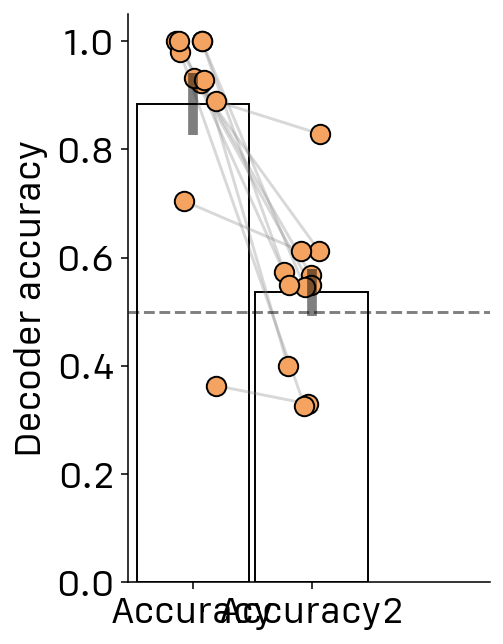

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

# Assuming df is already loaded with your provided structure

# Reshape the DataFrame to long format with 'condition' and 'value'
df_long = pd.melt(df.reset_index(), id_vars=['ID'], value_vars=['Accuracy', 'Accuracy2'], var_name='condition', value_name='value')

# Generate random jitter for the x-positions (0 for Accuracy and 1 for Accuracy2)
jitter_strength = 0.1
df_long['jittered_x'] = np.random.normal(loc=df_long['condition'].map({'Accuracy': 0, 'Accuracy2': 1}), 
                                         scale=jitter_strength, size=len(df_long))
print(df_long)


plt.figure(figsize=(4, 5))

# Plot bars for means and SEMs
means = df[['Accuracy', 'Accuracy2']].mean(axis=0)
sems = df[['Accuracy', 'Accuracy2']].sem(axis=0)
plt.bar(['Accuracy', 'Accuracy2'], means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, 
        error_kw=dict(lw=5, alpha=0.5, zorder=4), zorder=0)

# Plot scatter points with jitter (using df_long['jittered_x'])
plt.scatter(df_long['jittered_x'], df_long['value'], color='sandybrown', edgecolor='black', s=100, zorder=3)

# Plot lines connecting Accuracy and Accuracy2 for each individual, using jittered x-values from df_long

for ID in df['ID'].unique():
    # Extract jittered x-values for Accuracy and Accuracy2 from df_long
    accuracy_jittered_x = df_long.loc[(df_long['condition'] == 'Accuracy') & (df_long['ID'] == ID), 'jittered_x'].values[0]
    accuracy2_jittered_x = df_long.loc[(df_long['condition'] == 'Accuracy2') & (df_long['ID'] == ID), 'jittered_x'].values[0]
    
    # Extract corresponding Accuracy and Accuracy2 values
    accuracy_value = df.loc[df['ID'] == ID, 'Accuracy'].values[0]
    accuracy2_value = df.loc[df['ID'] == ID, 'Accuracy2'].values[0]
    
    # Plot the line between jittered x-values for Accuracy and Accuracy2
    plt.plot([accuracy_jittered_x, accuracy2_jittered_x], [accuracy_value, accuracy2_value], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/SAMEPM_Ymaze_Accuracy.pdf', format='pdf')
plt.show()



trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1034


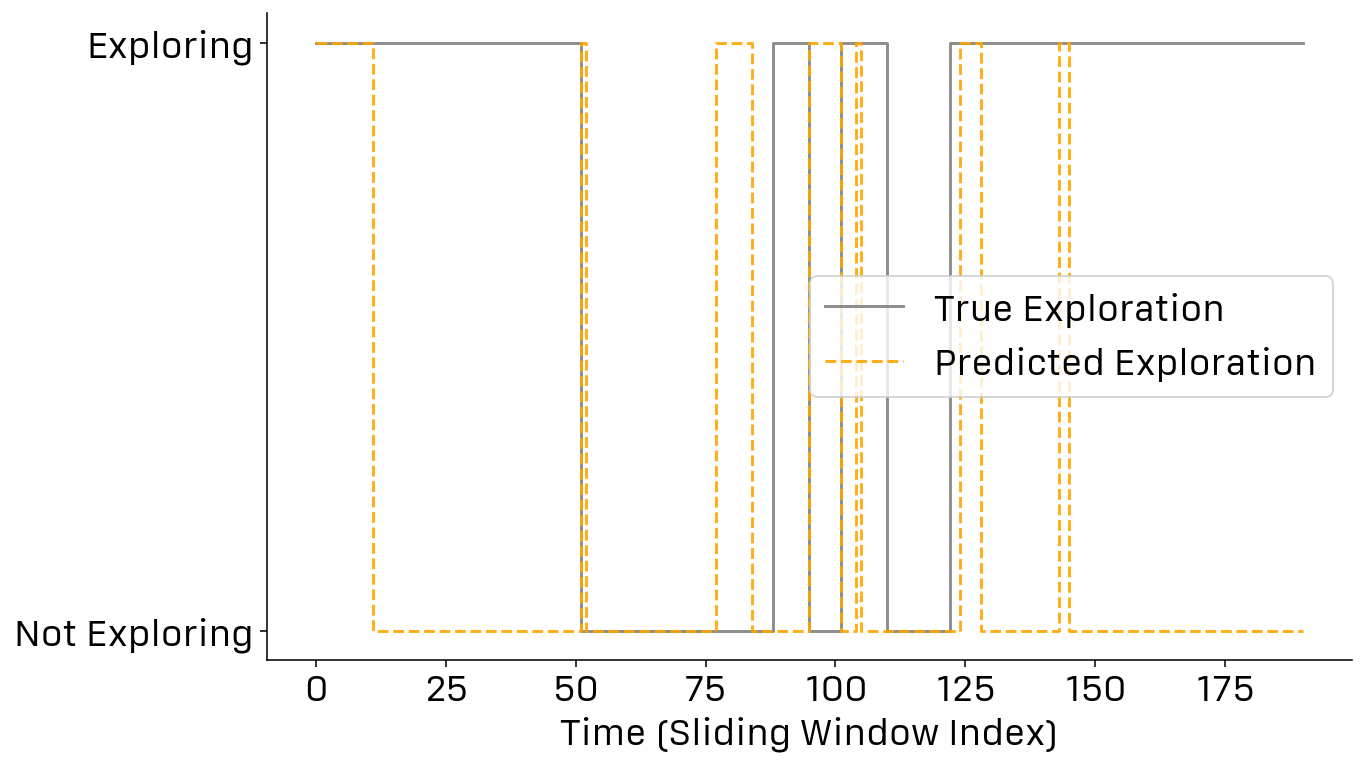

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 129


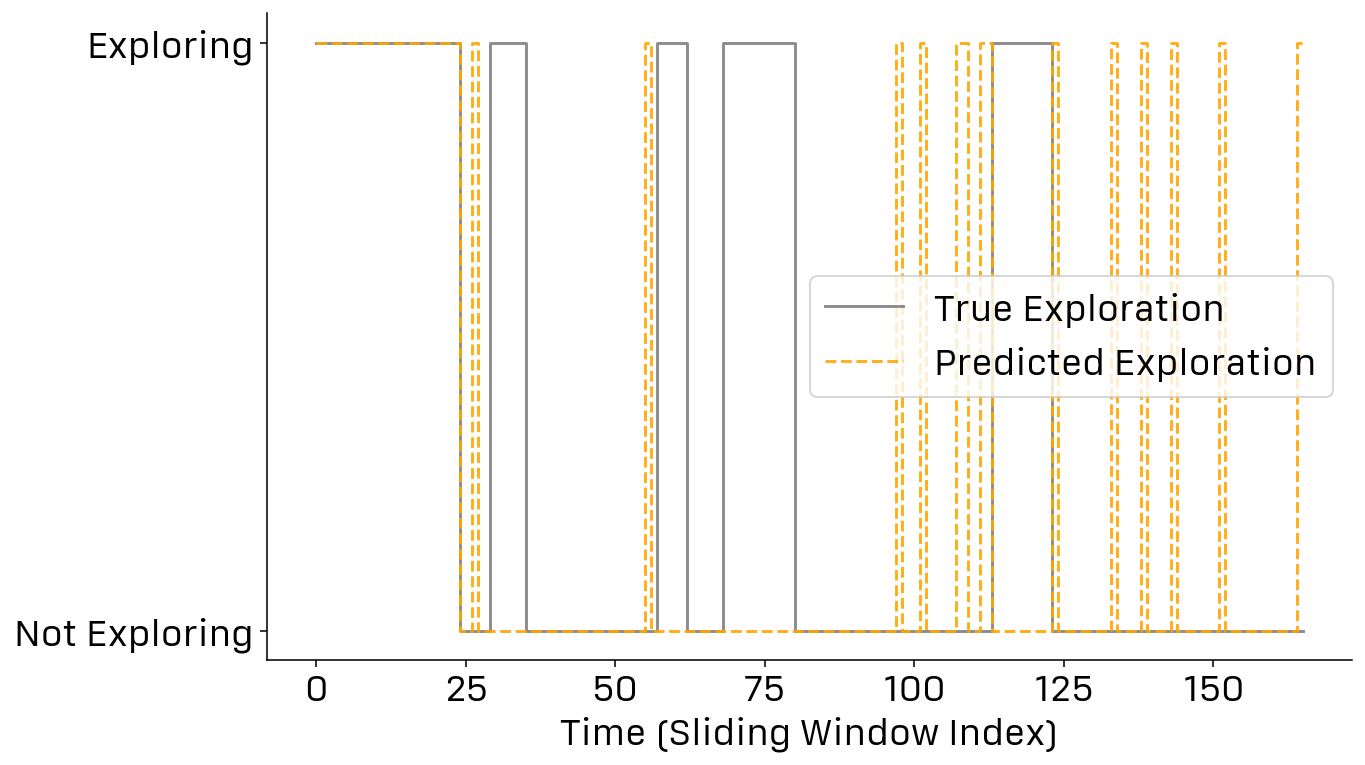

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1051


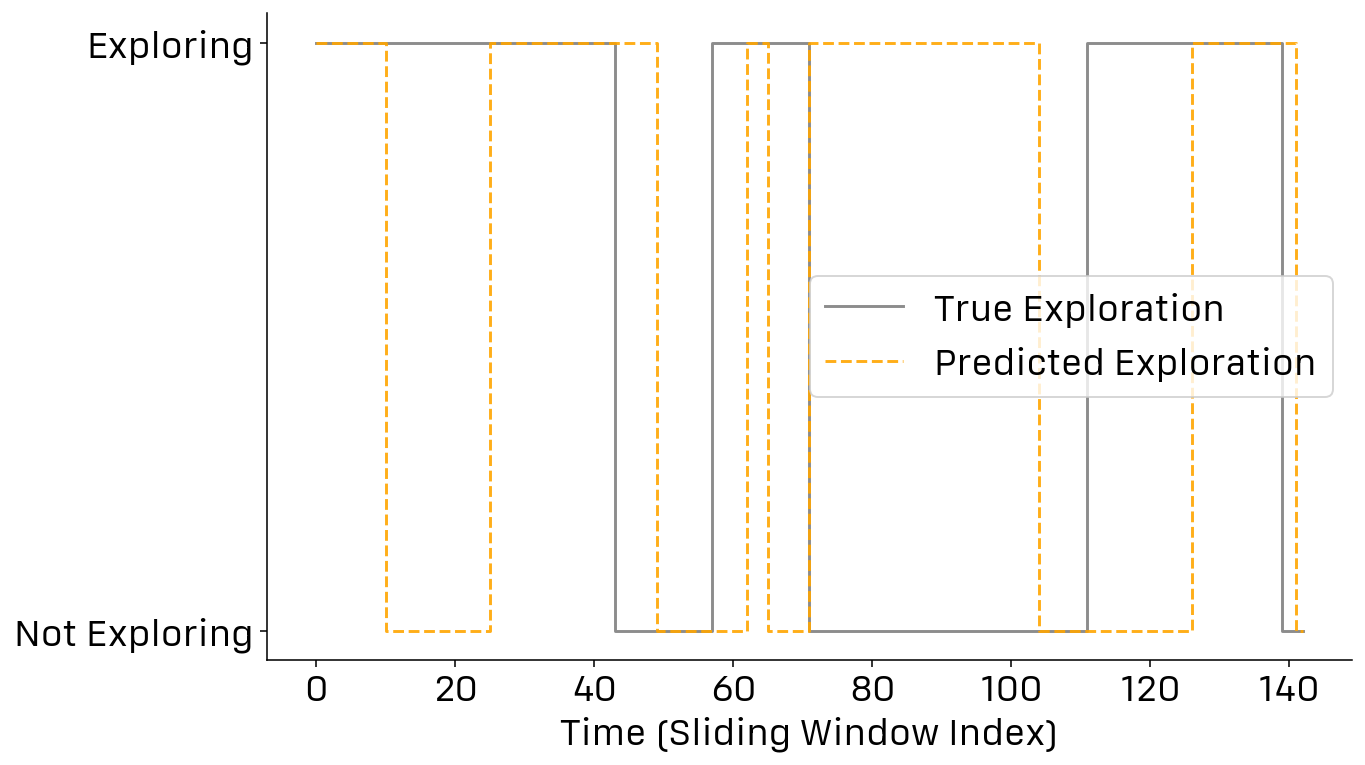

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1052


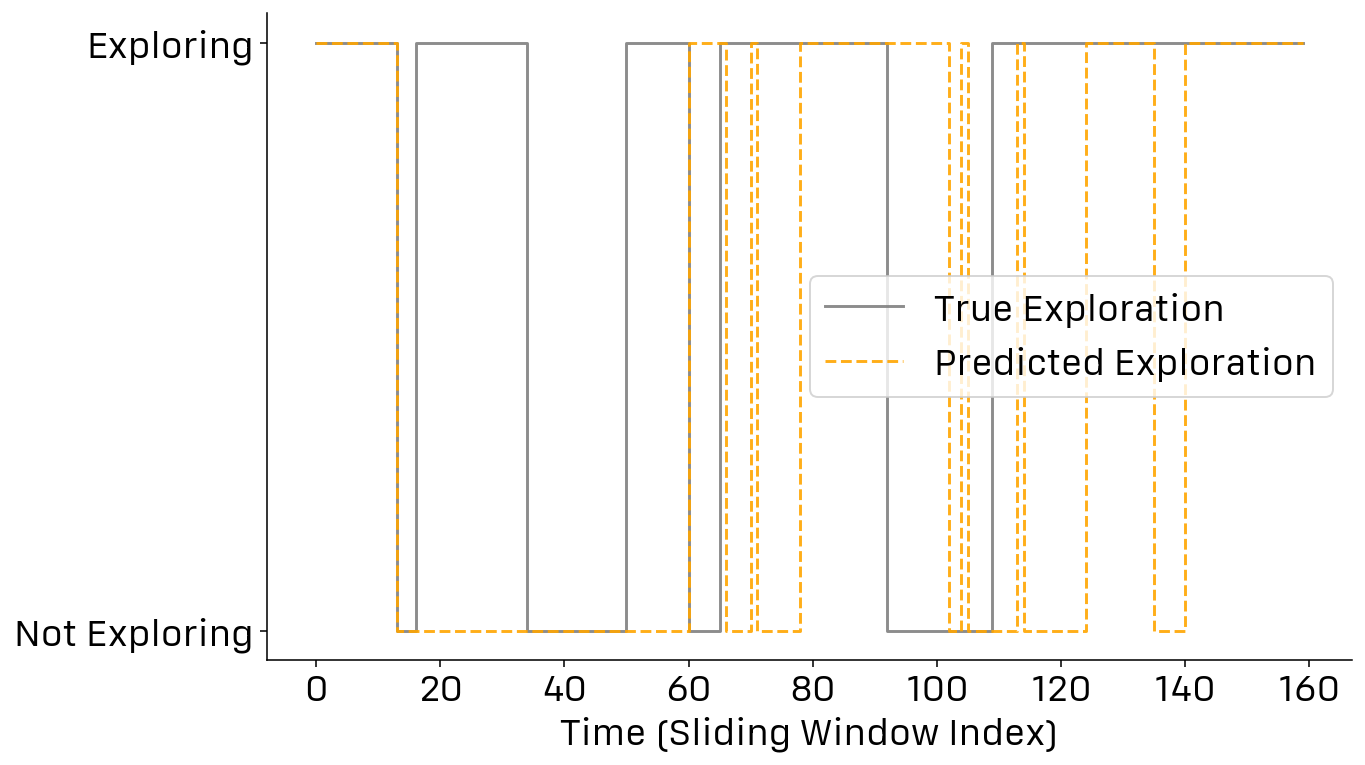

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 116


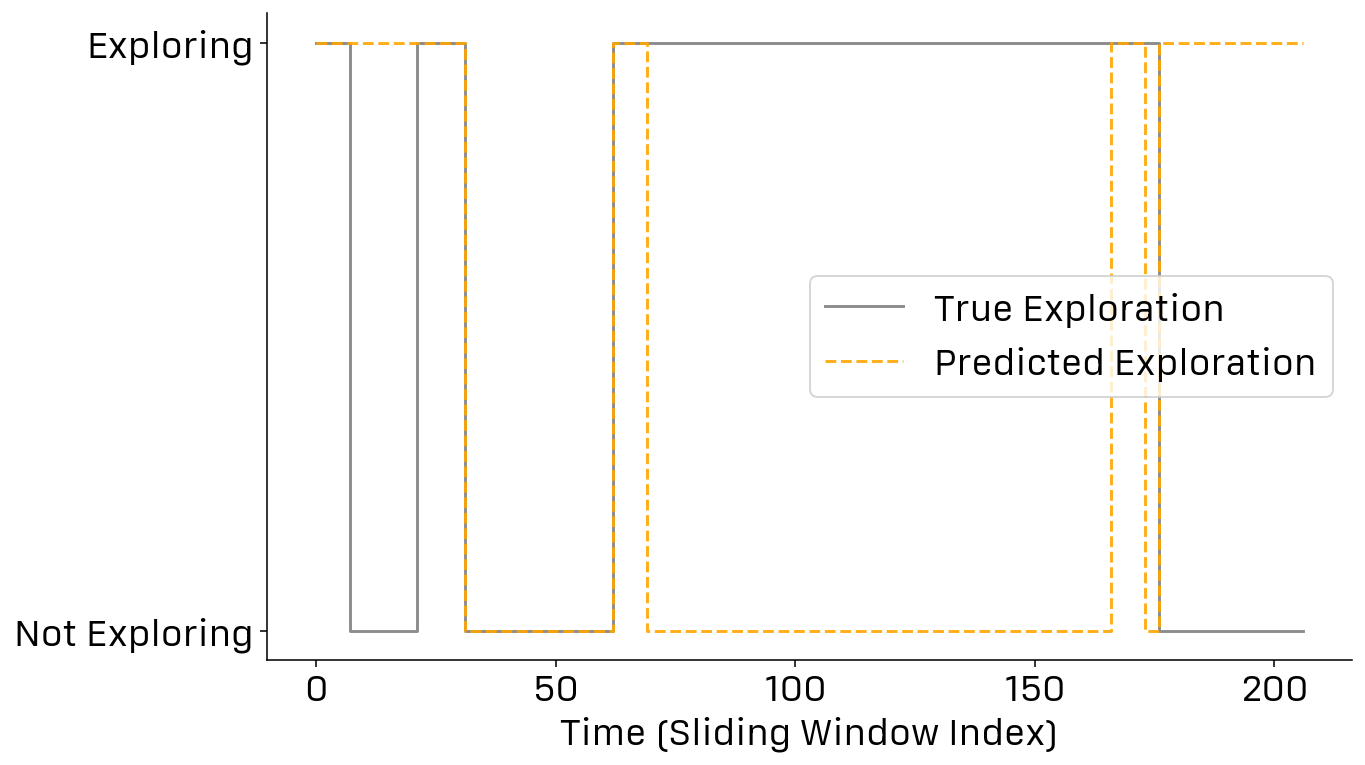

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1050


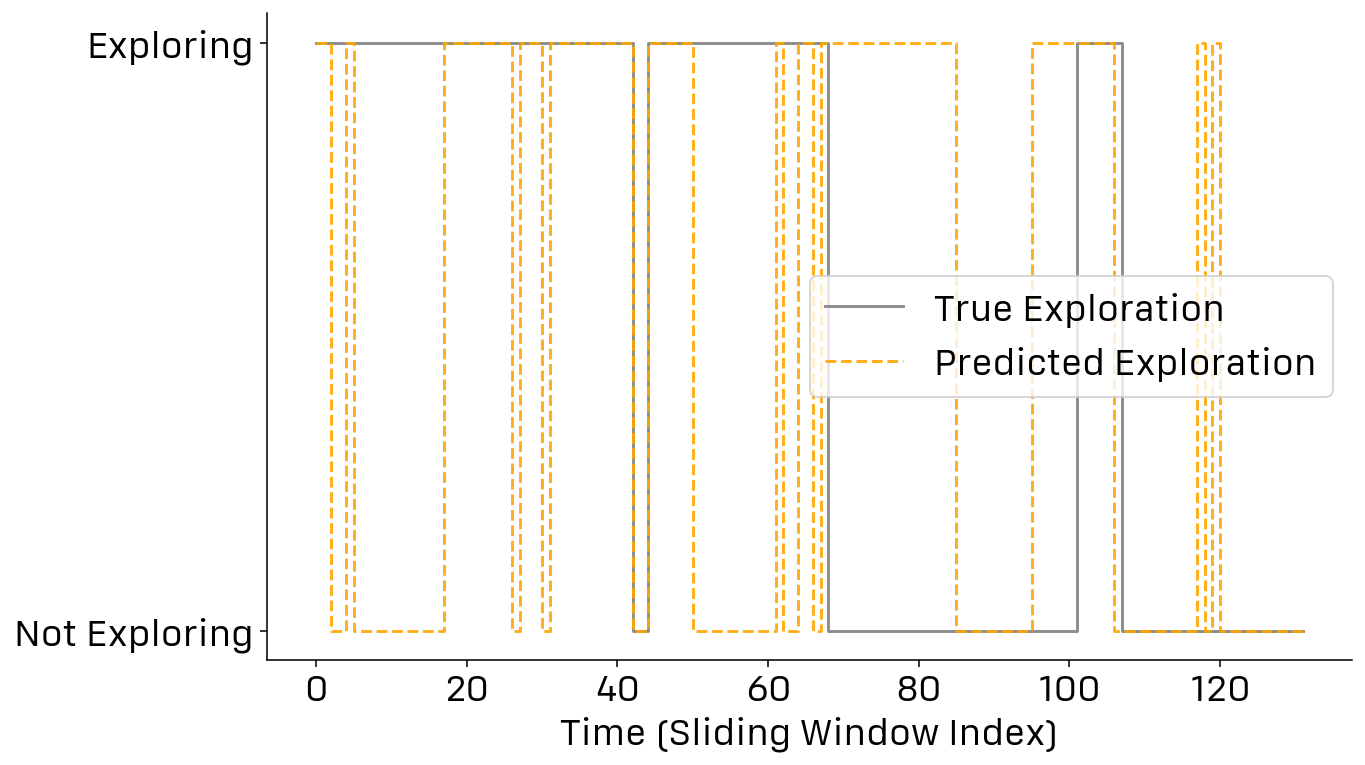

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 118


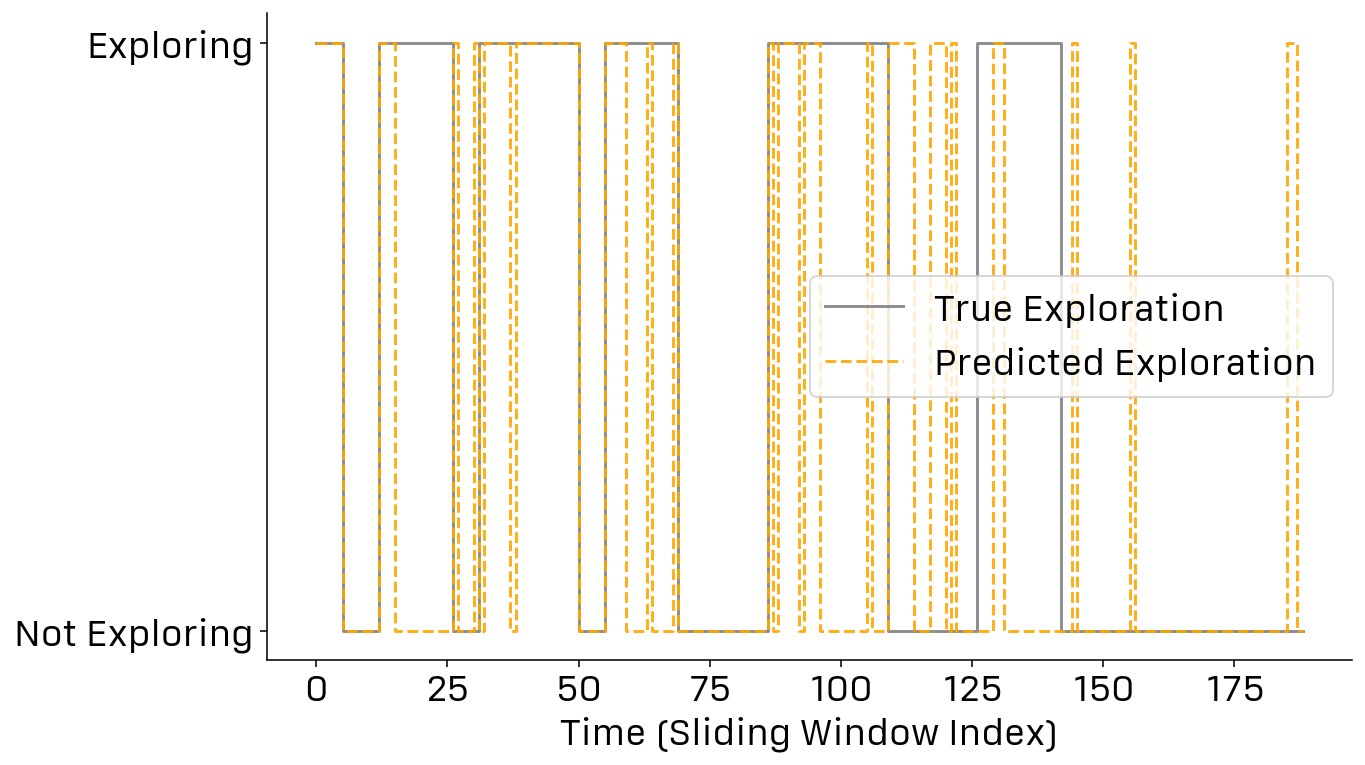

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1035


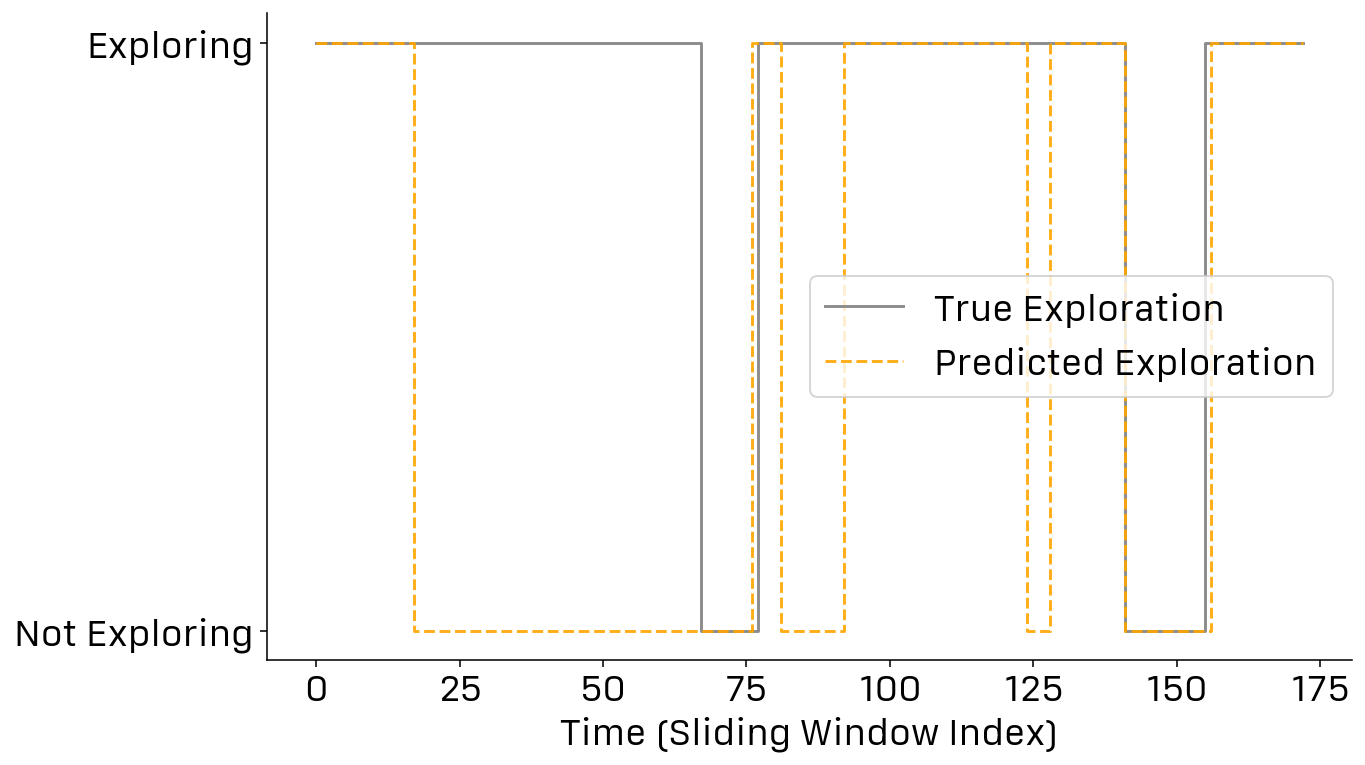

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1028


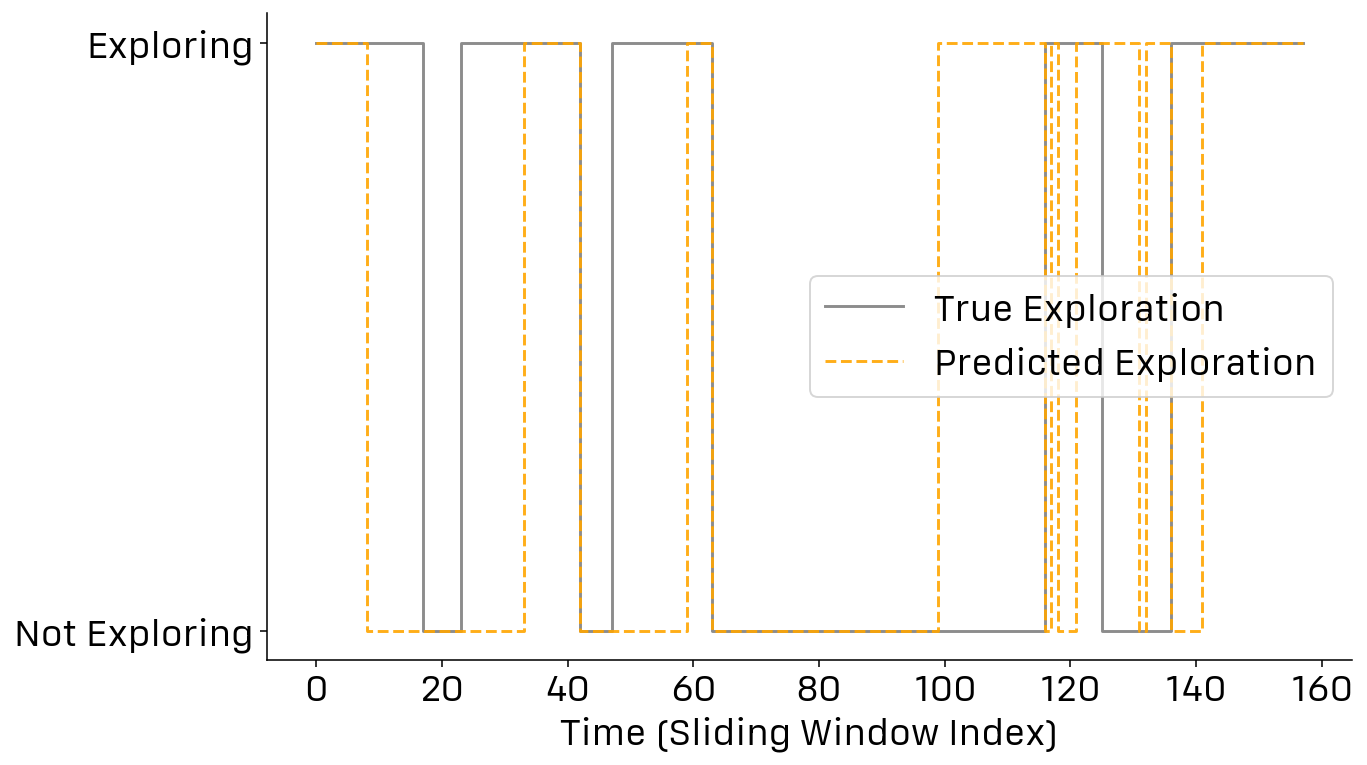

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1046


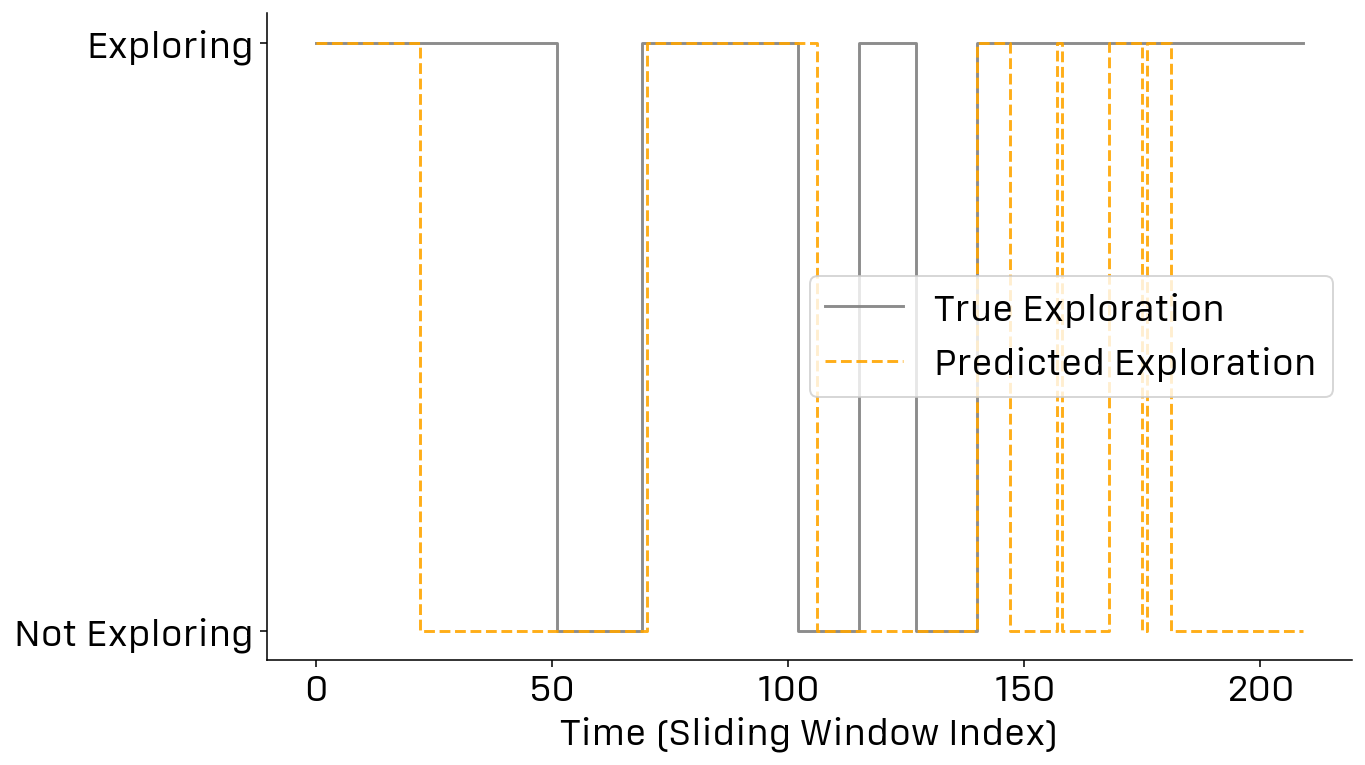

trak NOT subset; don't know how to subset; dropped


MOUSE,   ID: 1045


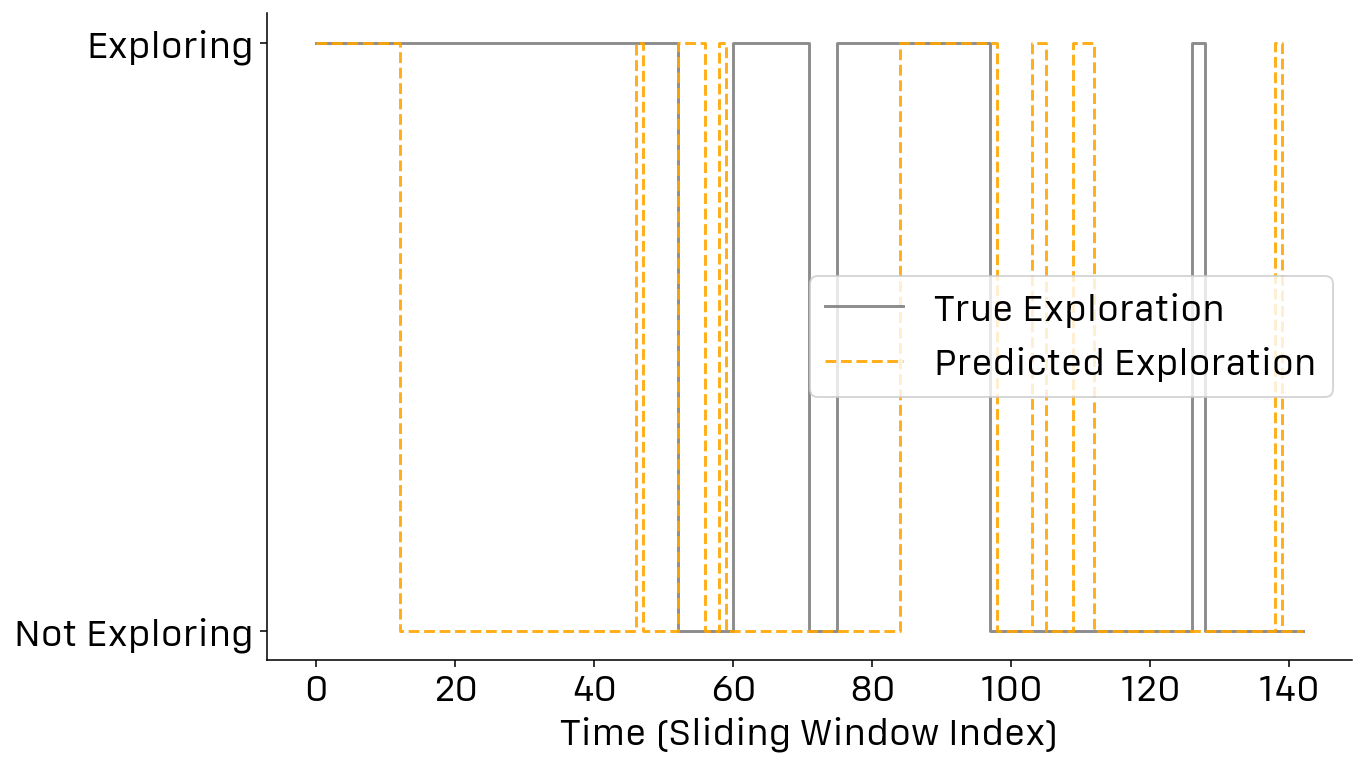

In [151]:
### DECODER FIRST EXPLO VS REST 

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files


#Ymaze

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/preprocessed/'
ymaze_files = glob.glob(os.path.join(directory, "*.csv"))

ymaze_files




for efile, sfile, yfile, in zip(epm_files, sam_files, ymaze_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)

    ym = pd.read_csv(yfile)

    id=epm['ID'].iloc[0]

    # Preprocess epm data
    epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
    epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Preprocess sam data
    sam.loc[sam['In black'] == 1, 'exploration'] = 0
    sam.loc[sam['In black'] == 0, 'exploration'] = 1
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Concat epm + sam
    epm_sam = pd.concat([epm, sam], axis=0)


    ### Preprocess ym data

    # ym['In farm'] = 0
    # ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1


  
    # explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    # exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    # ymtest = ym.loc[explostart:]

    # nexplostart = ymtest[(ymtest['In farm'].shift() == 0) & (ymtest['In farm'] == 1)].index
    # nexploend = ymtest[(ymtest['In farm'].shift() == 1) & (ymtest['In farm'] == 0)].index

    # validnexplostart = []
    # validnexploend = []

    # for start, end in zip(nexplostart, nexploend):
    #     if end-start > 300:  ### keep only the first explo that is longer than 5 seconds
    #         validnexplostart.append(start)
    #         validnexploend.append(end)


    # ymfirstexplo = pd.concat([ym.loc[explostart:exploend], ym.loc[validnexplostart[0]:validnexploend[0]]])


    # ymfirstexplo['exploration'] = 0
    # ymfirstexplo.loc[ymfirstexplo['In Novelarm'] == 1, 'exploration'] = 1

    # ### dataset against other explo 

    # ymotherexplo = ym.loc[validnexploend[0]:]
    # ymotherexplo = ymotherexplo[(ymotherexplo['In Novelarm'] == 1) | (ymotherexplo['In farm'] == 1)]


    # ymotherexplo['exploration'] = 0
    # ymotherexplo.loc[ymotherexplo['In Novelarm'] == 1, 'exploration'] = 1
    # ymotherexplo.loc[ymotherexplo['In farm'] == 1, 'exploration'] = 0


    ##############

    ym['In farm'] = 0
    ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1



    explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    ym = ym.loc[explostart:explostart+60*180]

    ym['exploration'] = np.nan
    ym.loc[ym['In Novelarm'] == 1, 'exploration'] = 1
    ym.loc[ym['In farm'] == 1, 'exploration'] = 0
    # ym.loc[ym['In middle'] == 0, 'exploration'] = 0
    ym = ym.dropna().reset_index(drop=True)




    # Parameters
    window_size = 300  # Sliding window size

    # Prepare training and testing datasets
    X_train, y_train = create_sliding_window(epm_sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(ym, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    ## Model training ##############################

    # Random undersampling
    undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    # Hyperparameter tuning
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
    lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
    grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_resampled, y_train_resampled)

        ## Model evaluation FIRST explo ##############################

    # Predict probabilities for AUC-ROC calculation
    y_pred_proba = best_model.predict_proba(X_test)

    y_pred = best_model.predict(X_test)


    # Visualize predictions vs true values

    print('MOUSE,   ID:', id)
    plt.figure(figsize=(10, 6))
    plt.step(range(len(y_test)), y_test, label='True Exploration', color='grey', alpha=0.9)
    plt.step(range(len(y_pred)), y_pred, label='Predicted Exploration', color='orange', linestyle='--', alpha=0.9)
    plt.xlabel('Time (Sliding Window Index)')
    plt.yticks([0, 1], ['Not Exploring', 'Exploring'])
    plt.legend()
    plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/ymazedecoder/fullexplo{id}.pdf', format='pdf')
    plt.show()




## Ymaze firs vs shuffled and other vs shuffled

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10
Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10
Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10
Repeat 1/10
Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10
Repeat 3/10
Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.92857

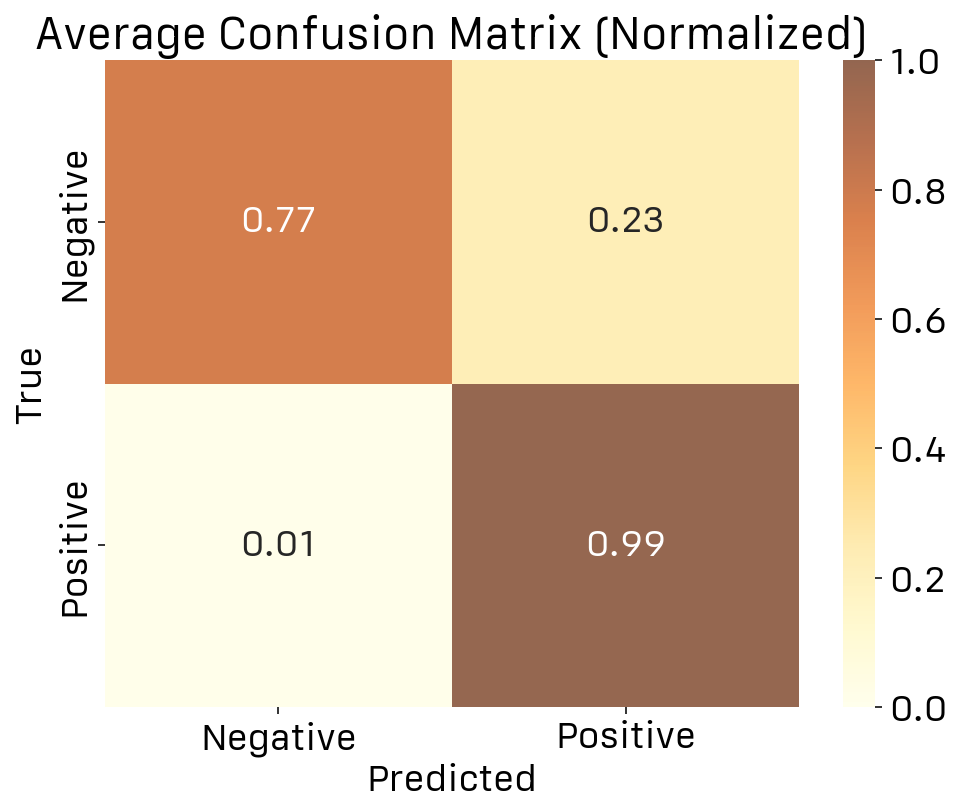

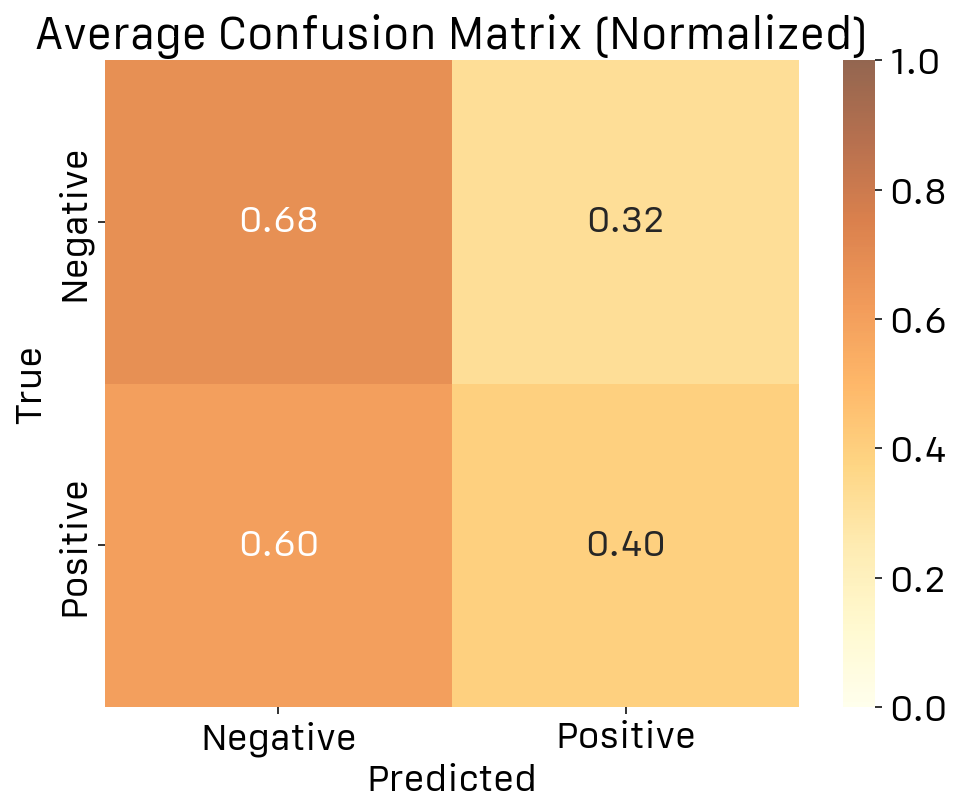

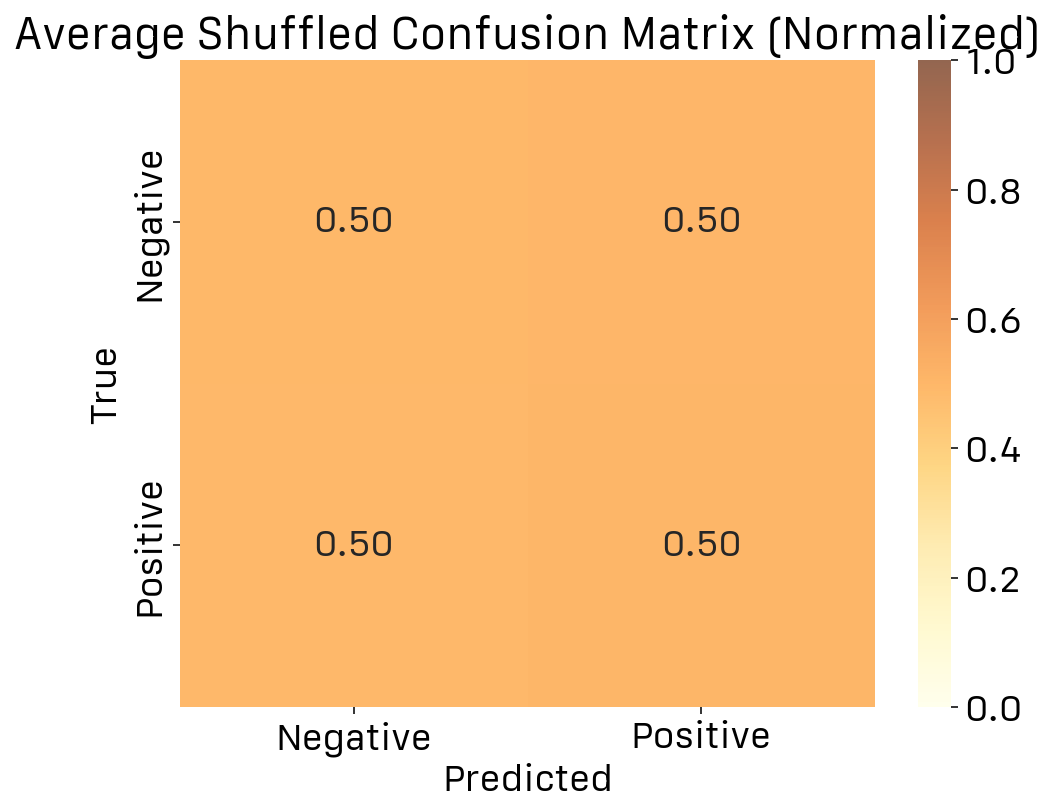

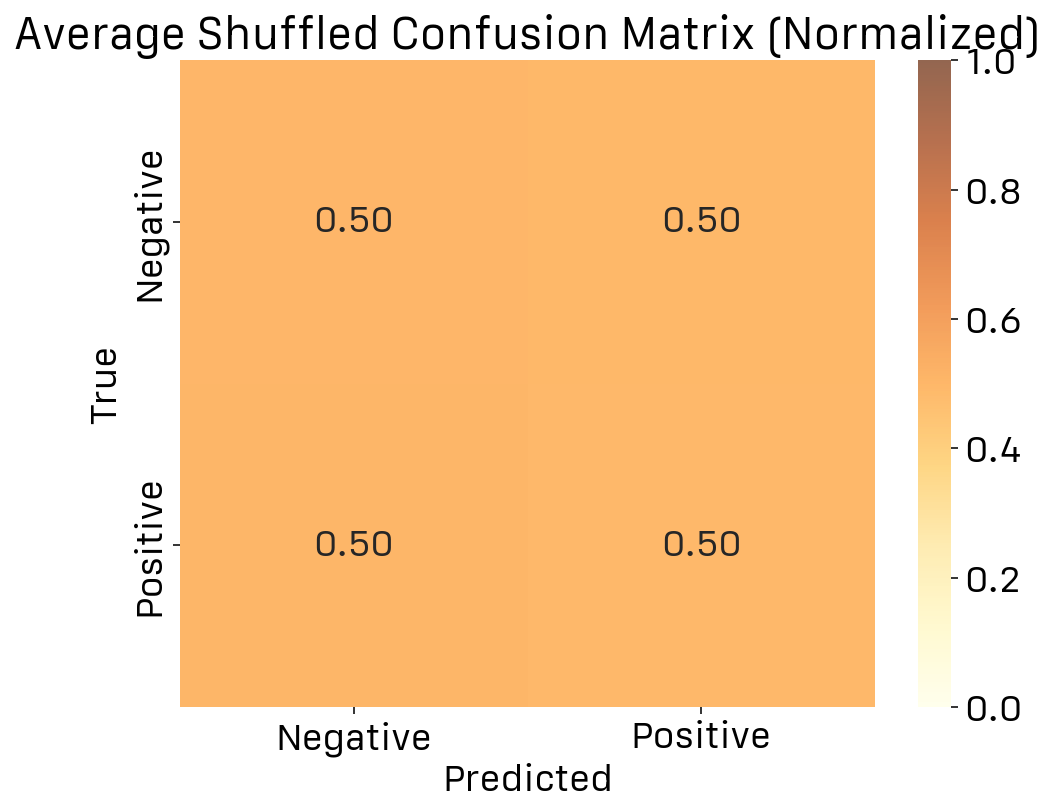

In [26]:
### DECODER FIRST EXPLO VS REST 

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files


#Ymaze

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/preprocessed/'
ymaze_files = glob.glob(os.path.join(directory, "*.csv"))

ymaze_files


# Initialize results storage
confusion_matrices = []
confusion_matrices2 = []
shuffled_confusion_matrices = []
shuffled_confusion_matrices2 = []

results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [], 'Accuracy2': [], 
              'Precision2': [], 'Recall2': [], 'F12': [], '1_f12': [], '0_f12': [], 'AUC_ROC2': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': [], 
           'Shuffled_Accuracy2': [], 'Shuffled_Precision2': [], 'Shuffled_Recall2': [],
           'Shuffled_F12': [], 'Shuffled_1_f12': [], 'Shuffled_0_f12': [], 'Shuffled_AUC_ROC2': []}

num_repeats = 10  # number of under-sampling repeats


for efile, sfile, yfile, in zip(epm_files, sam_files, ymaze_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)

    ym = pd.read_csv(yfile)

    id=epm['ID'].iloc[0]

    # Preprocess epm data
    epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
    epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
    epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Preprocess sam data
    sam.loc[sam['In black'] == 1, 'exploration'] = 0
    sam.loc[sam['In black'] == 0, 'exploration'] = 1
    sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

    # Concat epm + sam
    epm_sam = pd.concat([epm, sam], axis=0)


    # Preprocess ym data


    ym['In farm'] = 0
    ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1


  
    explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    ymtest = ym.loc[explostart:]

    nexplostart = ymtest[(ymtest['In farm'].shift() == 0) & (ymtest['In farm'] == 1)].index
    nexploend = ymtest[(ymtest['In farm'].shift() == 1) & (ymtest['In farm'] == 0)].index

    validnexplostart = []
    validnexploend = []

    for start, end in zip(nexplostart, nexploend):
        if end-start > 300:  ### keep only the first explo that is longer than 5 seconds
            validnexplostart.append(start)
            validnexploend.append(end)


    ymfirstexplo = pd.concat([ym.loc[explostart:exploend], ym.loc[validnexplostart[0]:validnexploend[0]]])


    ymfirstexplo['exploration'] = 0
    ymfirstexplo.loc[ymfirstexplo['In Novelarm'] == 1, 'exploration'] = 1

    ### dataset against other explo 

    ymotherexplo = ym.loc[validnexploend[0]:]
    ymotherexplo = ymotherexplo[(ymotherexplo['In Novelarm'] == 1) | (ymotherexplo['In farm'] == 1)]


    ymotherexplo['exploration'] = 0
    ymotherexplo.loc[ymotherexplo['In Novelarm'] == 1, 'exploration'] = 1
    ymotherexplo.loc[ymotherexplo['In farm'] == 1, 'exploration'] = 0




    # Parameters
    window_size = 300  # Sliding window size

    # Prepare training and testing datasets
    X_train, y_train = create_sliding_window(epm_sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_testfirstexplo, y_testfirstexplo = create_sliding_window(ymfirstexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_testotherexplo, y_testotherexplo = create_sliding_window(ymotherexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        ## Model training ##############################

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)

         ## Model evaluation FIRST explo ##############################

        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testfirstexplo)

        y_pred = best_model.predict(X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_testfirstexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_testfirstexplo, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_testfirstexplo, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)

         ## Model evaluation ALL OTHER EXPLO ##############################


        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testotherexplo)
        y_pred = best_model.predict(X_testotherexplo)

        # Compute AUC-ROC
        auc_roc2 = roc_auc_score(y_testotherexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm2 = confusion_matrix(y_testotherexplo, y_pred, normalize='true')
        confusion_matrices2.append(cm2)

        report = classification_report(y_testotherexplo, y_pred, output_dict=True)
        results['Accuracy2'].append(report['accuracy'])
        results['Precision2'].append(report['weighted avg']['precision'])
        results['Recall2'].append(report['weighted avg']['recall'])
        results['F12'].append(report['weighted avg']['f1-score'])
        results['1_f12'].append(report['1']['f1-score'])
        results['0_f12'].append(report['0']['f1-score'])
        results['AUC_ROC2'].append(auc_roc2)



        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_cm_list2 = []
        shuffled_results_list = []
        shuffled_results_list2 = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            ####### first explo

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testfirstexplo)
            y_pred_shuffled = best_model.predict(X_testfirstexplo)

            shuffled_auc_roc = roc_auc_score(y_testfirstexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_testfirstexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_testfirstexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)

            ######## other explo

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testotherexplo)
            y_pred_shuffled = best_model.predict(X_testotherexplo)

            shuffled_auc_roc2 = roc_auc_score(y_testotherexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report2 = classification_report(y_testotherexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list2.append({
                'Shuffled_Accuracy2': shuffled_report2['accuracy'],
                'Shuffled_Precision2': shuffled_report2['weighted avg']['precision'],
                'Shuffled_Recall2': shuffled_report2['weighted avg']['recall'],
                'Shuffled_F12': shuffled_report2['weighted avg']['f1-score'],
                'Shuffled_1_f12': shuffled_report2['1']['f1-score'],
                'Shuffled_0_f12': shuffled_report2['0']['f1-score'],
                'Shuffled_AUC_ROC2': shuffled_auc_roc2
            })

            cm_shuffled2 = confusion_matrix(y_testotherexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list2.append(cm_shuffled2)

        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        avg_shuffled_cm2 = np.mean(shuffled_cm_list2, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }
        shuffled_average_results2 = {
            key: np.mean([res[key] for res in shuffled_results_list2]) for key in shuffled_results_list2[0]
        }

        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])


        results['Shuffled_Accuracy2'].append(shuffled_average_results2['Shuffled_Accuracy2'])
        results['Shuffled_Precision2'].append(shuffled_average_results2['Shuffled_Precision2'])
        results['Shuffled_Recall2'].append(shuffled_average_results2['Shuffled_Recall2'])
        results['Shuffled_F12'].append(shuffled_average_results2['Shuffled_F12'])
        results['Shuffled_1_f12'].append(shuffled_average_results2['Shuffled_1_f12'])
        results['Shuffled_0_f12'].append(shuffled_average_results2['Shuffled_0_f12'])
        results['Shuffled_AUC_ROC2'].append(shuffled_average_results2['Shuffled_AUC_ROC2'])

        shuffled_confusion_matrices.append(avg_shuffled_cm)
        shuffled_confusion_matrices2.append(avg_shuffled_cm2)

# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
average_cm2 = np.mean(confusion_matrices2, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)
shuffled_average_cm2 = np.mean(shuffled_confusion_matrices2, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices

#### DATA FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexplo.pdf', format='pdf')
plt.show()


### DATA OTHER EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexplo.pdf', format='pdf')
plt.show()

### SHUFFLED FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexploSHUFFLED.pdf', format='pdf')
plt.show()

### SHUFFLED OTHER EXPLO

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexploSHUFFLED.pdf', format='pdf')
plt.show()


      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1966786438.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1966786438.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirsrexplo_Accuracy.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


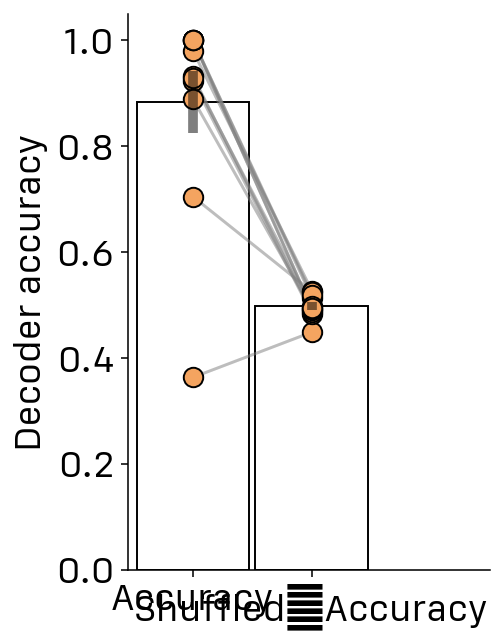

In [ ]:
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Shuffled_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Shuffled_Accuracy'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Shuffled_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirsrexplo_Accuracy.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/2913143166.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/2913143166.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/YmazeOtherexplo_Accuracy.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


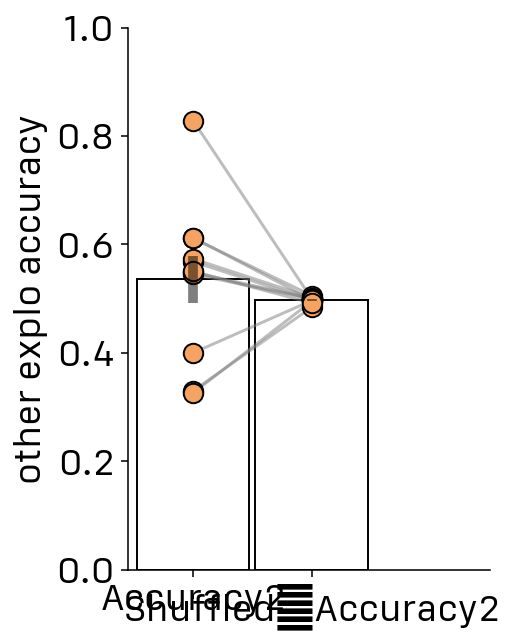

In [ ]:
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy2', 'Shuffled_Accuracy2']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy2'], df['Shuffled_Accuracy2'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy2'], row['Shuffled_Accuracy2']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('other explo accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/YmazeOtherexplo_Accuracy.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3532657661.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3532657661.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_F1.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


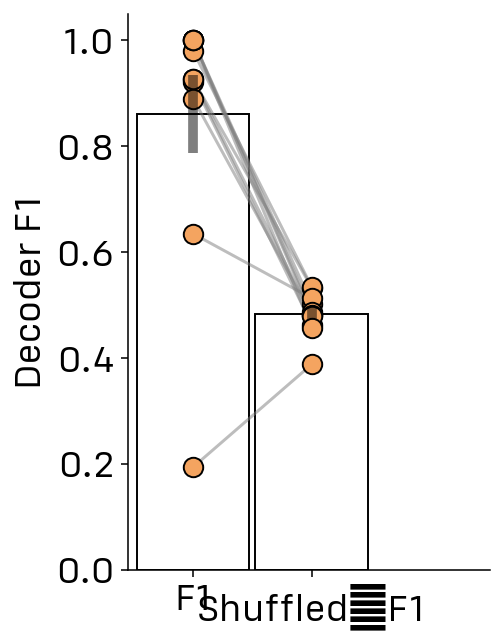

In [ ]:

df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Shuffled_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Shuffled_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Shuffled_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_F1.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3441909045.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/3441909045.py:31: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_F1.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


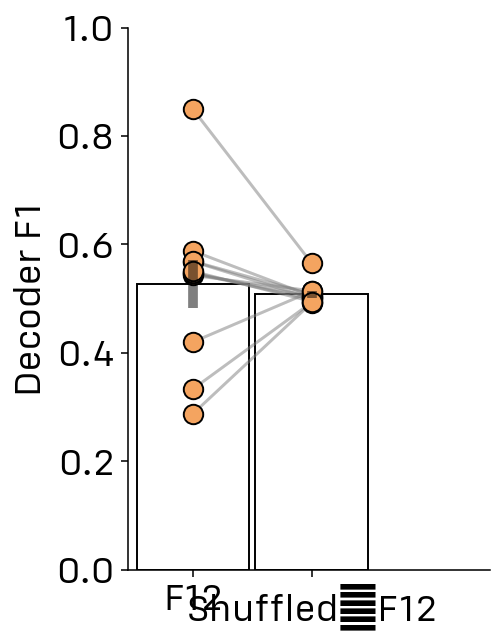

In [ ]:


df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F12', 'Shuffled_F12']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F12'], df['Shuffled_F12'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F12'], row['Shuffled_F12']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_F1.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/4270005714.py:24: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/4270005714.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_Precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


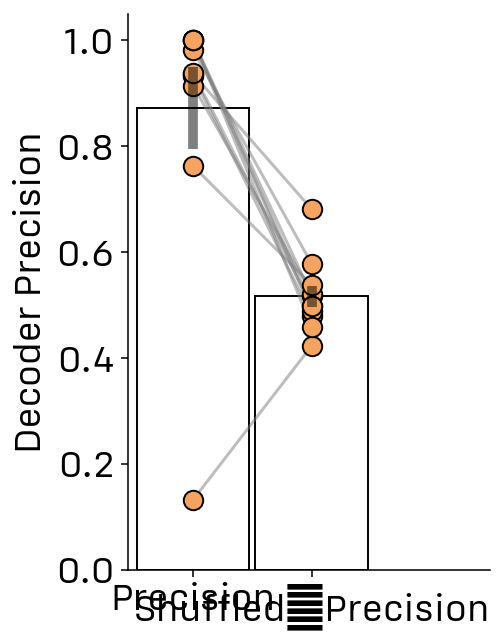

In [17]:


df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision', 'Shuffled_Precision']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Shuffled_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Shuffled_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_Precision.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1843011950.py:24: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1843011950.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_Precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


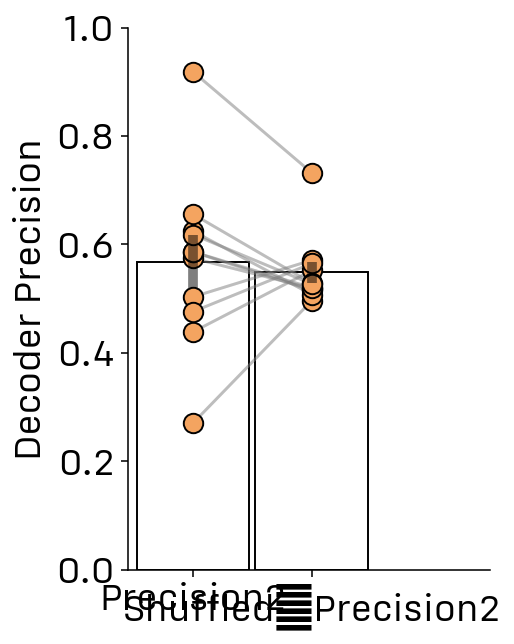

In [18]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision2', 'Shuffled_Precision2']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision2'], df['Shuffled_Precision2'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision2'], row['Shuffled_Precision2']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_Precision.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1819650193.py:24: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1819650193.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_Recall.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


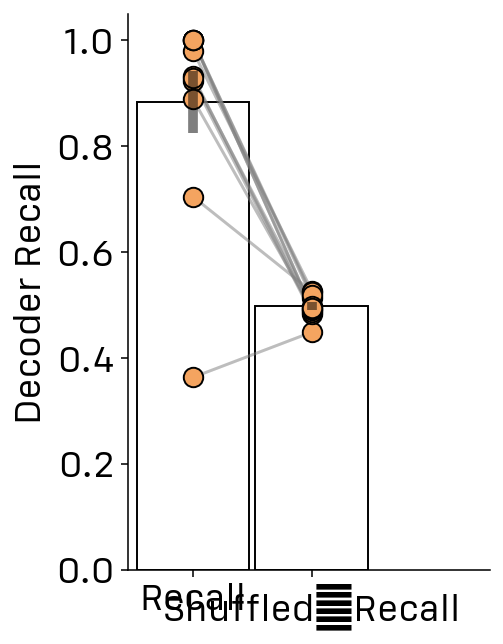

In [19]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Shuffled_Recall']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall'], df['Shuffled_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Shuffled_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_Recall.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/2324761520.py:24: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/2324761520.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_Recall.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


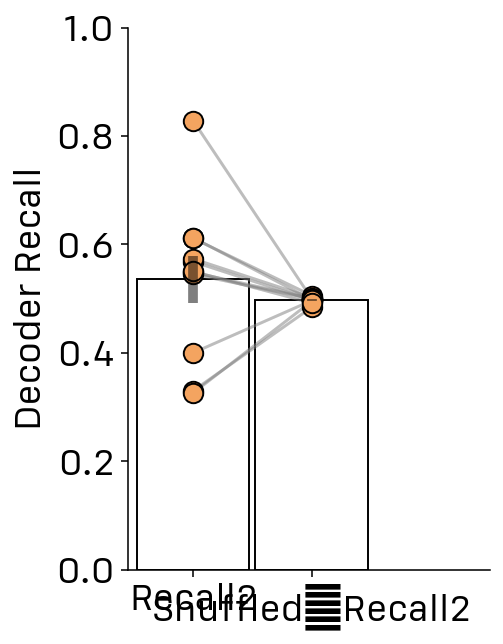

In [21]:


df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall2', 'Shuffled_Recall2']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall2'], df['Shuffled_Recall2'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall2'], row['Shuffled_Recall2']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_Recall.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1166572372.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1166572372.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_AUC_ROC.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


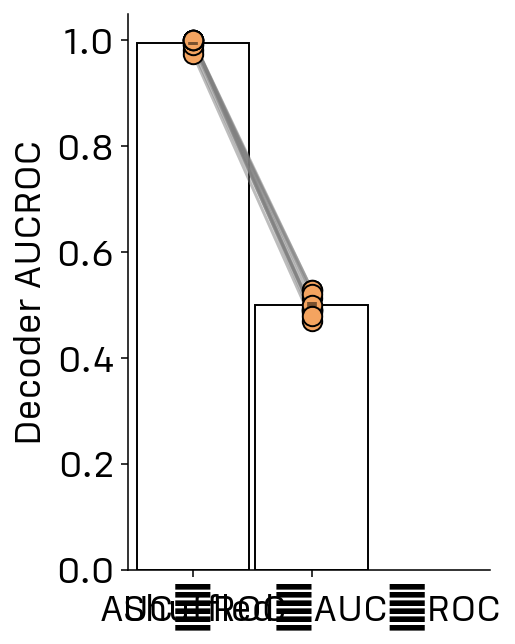

In [27]:


df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC', 'Shuffled_AUC_ROC']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC'], df['Shuffled_AUC_ROC'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC'], row['Shuffled_AUC_ROC']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder AUCROC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazefirstexplo_AUC_ROC.pdf', format='pdf')
plt.show()

      Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                            
116   0.363636   0.132231  0.363636  0.193939  0.533333  0.000000  0.981250   
118   0.923077   0.933077  0.923077  0.921772  0.917879  0.925108  0.973810   
129   0.932258   0.936757  0.932258  0.926378  0.959472  0.788485  0.992667   
1028  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1034  0.980000   0.981538  0.980000  0.980178  0.972000  0.984444  1.000000   
1035  0.888889   0.914336  0.888889  0.890208  0.875686  0.899449  1.000000   
1045  0.704762   0.762853  0.704762  0.634894  0.808038  0.353535  0.991346   
1046  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1050  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1051  0.928571   0.939048  0.928571  0.926614  0.942484  0.905455  1.000000   
1052  1.000000   1.000000  1.000000  1.000000  1.000

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1535387768.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_18552/1535387768.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_AUC_ROC.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


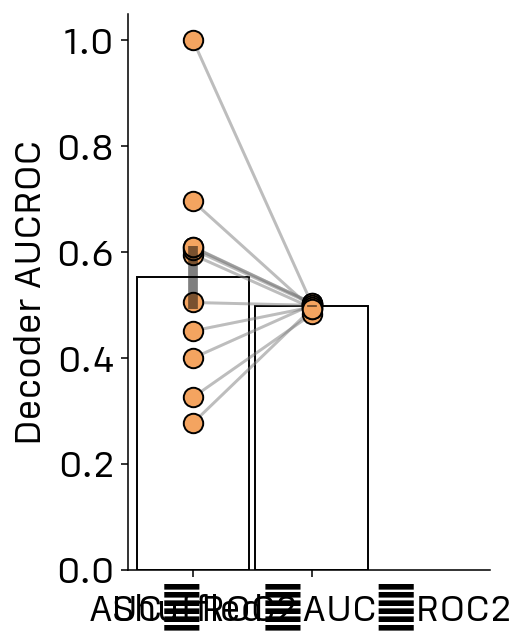

In [28]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC2', 'Shuffled_AUC_ROC2']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC2'], df['Shuffled_AUC_ROC2'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC2'], row['Shuffled_AUC_ROC2']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder AUCROC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Ymazeotherexplo_AUC_ROC.pdf', format='pdf')
plt.show()